(template_notebook)=
# Bayesian Workflow with SEMs 

:::{post} Novemeber, 2025
:tags: confirmatory factor analysis, structural equation models, 
:category: advanced, reference
:author: Nathaniel Forde
:::

This is some introductory text. Consult the [style guide](https://docs.pymc.io/en/latest/contributing/jupyter_style.html).

In [49]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Job Satisfaction and Bayesian Workflows

In [5]:

# | code-fold: true

# Standard deviations
stds = np.array([0.939, 1.017, 0.937, 0.562, 0.760, 0.524, 
                 0.585, 0.609, 0.731, 0.711, 1.124, 1.001])

n = len(stds)

# Lower triangular correlation values as a flat list
corr_values = [
    1.000,
    .668, 1.000,
    .635, .599, 1.000,
    .263, .261, .164, 1.000,
    .290, .315, .247, .486, 1.000,
    .207, .245, .231, .251, .449, 1.000,
   -.206, -.182, -.195, -.309, -.266, -.142, 1.000,
   -.280, -.241, -.238, -.344, -.305, -.230,  .753, 1.000,
   -.258, -.244, -.185, -.255, -.255, -.215,  .554,  .587, 1.000,
    .080,  .096,  .094, -.017,  .151,  .141, -.074, -.111,  .016, 1.000,
    .061,  .028, -.035, -.058, -.051, -.003, -.040, -.040, -.018,  .284, 1.000,
    .113,  .174,  .059,  .063,  .138,  .044, -.119, -.073, -.084,  .563,  .379, 1.000
]

# Fill correlation matrix
corr_matrix = np.zeros((n, n))
idx = 0
for i in range(n):
    for j in range(i+1):
        corr_matrix[i, j] = corr_values[idx]
        corr_matrix[j, i] = corr_values[idx]
        idx += 1

# Covariance matrix: Sigma = D * R * D
cov_matrix = np.outer(stds, stds) * corr_matrix
#cov_matrix_test = np.dot(np.dot(np.diag(stds), corr_matrix), np.diag(stds))
FEATURE_COLUMNS=["JW1","JW2","JW3", "UF1","UF2","FOR", "DA1","DA2","DA3", "EBA","ST","MI"]
corr_df = pd.DataFrame(corr_matrix, columns=FEATURE_COLUMNS)

cov_df = pd.DataFrame(cov_matrix, columns=FEATURE_COLUMNS)

def make_sample(cov_matrix, size, columns, missing_frac=0.0, impute=False):
    sample_df = pd.DataFrame(np.random.multivariate_normal([0]*12, cov_matrix, size=size), columns=FEATURE_COLUMNS)
    if missing_frac > 0.0: 
        total_values = sample_df.size
        num_nans = int(total_values * missing_frac)

        # Choose random flat indices
        nan_indices = np.random.choice(total_values, num_nans, replace=False)

        # Convert flat indices to (row, col)
        rows, cols = np.unravel_index(nan_indices, sample_df.shape)

        # Set the values to NaN
        sample_df.values[rows, cols] = np.nan

    if impute: 
        sample_df.fillna(sample_df.mean(axis=0), inplace=True)


    return sample_df

sample_df = make_sample(cov_matrix, 263, FEATURE_COLUMNS)
sample_df.head(10)

JW1       JW2       JW3       UF1       UF2       FOR       DA1  \
0 -0.355264 -0.138567 -0.416267  0.387040 -0.409966 -0.685045  0.551483   
1  3.135523  2.233013  1.686842  0.651217  0.436981  0.068051 -1.125376   
2  0.580981  1.436013  1.418568  0.169118  0.702554  0.352063 -0.847132   
3  2.225250  1.770181  1.448460  0.122075 -0.384125  0.341035 -0.744869   
4 -0.217553  0.362079 -0.174953 -0.019765  1.143683  0.654399 -0.193514   
5 -0.697347 -0.001249 -0.319558  0.363777  0.010874  0.177394 -0.075262   
6  0.372561  0.999235  1.099559  0.087096  0.991282 -0.276627  0.454742   
7  0.435557  0.256463  0.824628  0.182394  0.596904  0.175763 -0.411939   
8 -0.293234 -0.785348 -0.748749 -0.579486 -0.242783 -0.269153 -0.009257   
9  1.650896  0.958802  1.803148 -0.014083  0.295889 -0.430911  0.581749   

        DA2       DA3       EBA        ST        MI  
0  0.773278  0.125668  0.189472  0.939471  0.531176  
1 -1.490458 -1.587940 -1.337920 -0.978484 -0.712167  
2 -0.834597 -0.462754  1.817919  0.337847  1.349882  
3 -1.192972 -0.356887  0.338599 -0.249265 -0.654629  
4 -0.200546 -0.850478  0.741874  0.749728  0.173329  
5  0.337647  0.128512  0.090753 -2.111179  0.543911  
6  0.830033  1.016586  1.786522 -0.286415  2.089513  
7 -0.188678  0.023960  1.556906  0.797298  1.027437  
8  0.259637  0.683575 -0.588188  0.367622 -1.928123  
9  0.101228  0.264995  0.578845  0.923705  1.353942

## Confirmatory Factor Analysis

In [40]:
sample_df = make_sample(cov_matrix, 263, FEATURE_COLUMNS)

coords = {
    "obs": list(range(len(sample_df))),
    "indicators": FEATURE_COLUMNS,
    "indicators_1": ["JW1", "JW2",  "JW3"], # job satisfaction
    "indicators_2": ["UF1", "UF2", "FOR"], # well being
    "indicators_3": ["DA1", "DA2", "DA3"], # dysfunction
    "indicators_4": ["EBA", "ST", "MI"], # constructive thought strategies
    "latent": ["satisfaction", "well being", "dysfunctional", "constructive"],
    "latent1": ["satisfaction", "well being", "dysfunctional", "constructive"],
    "paths": ["dysfunctional ~ constructive", "well being ~ dysfunctional", "well being ~ constructive", "satisfaction ~ well being", "satisfaction ~ dysfunction" ,  "satisfaction ~ constructive"], 
    "sd_params": [i + '_sd' for i in FEATURE_COLUMNS],
    "corr_params": ['UF1 ~~ FOR']
}

def make_lambda(indicators, name='lambdas1', priors=[1, 10]):
    """ Takes an argument indicators which is a string in the coords dict"""
    temp_name = name + '_'
    lambdas_ = pm.Normal(temp_name, priors[0], priors[1], dims=(indicators))
    # Force a fixed scale on the factor loadings for factor 1
    lambdas_1 = pm.Deterministic(
        name, pt.set_subtensor(lambdas_[0], 1), dims=(indicators)
    )
    return lambdas_1

def make_B(priors=[0, .5]):
    coefs = pm.Normal('mu_betas', [0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], dims='paths')

    zeros = pt.zeros((4, 4))
    ## dysfunctional ~ constructive
    zeros = pt.set_subtensor(zeros[3, 2], coefs[0])
    ## well being ~ dysfunctional
    zeros = pt.set_subtensor(zeros[2, 1], coefs[1])
    ## well being ~ constructive
    zeros = pt.set_subtensor(zeros[3, 1], coefs[2])
    ## satisfaction ~ well being
    zeros = pt.set_subtensor(zeros[1, 0], coefs[3])
    ## satisfaction ~ dysfunction
    zeros = pt.set_subtensor(zeros[2, 0], coefs[4])
    ## satisfaction ~ constructive
    coefs_ = pt.set_subtensor(zeros[3, 0], coefs[5])
    return coefs_

def make_Psi(indicators, name='Psi_cov'):
    """ Takes an argument indicators which is a string in the coords dict"""
    temp_name = name + '_'
    n = len(coords[indicators])
    cov_params = pm.InverseGamma(temp_name, 3, 4, dims='sd_params')
    r = pt.zeros((n, n))
    beta_params = pm.Beta(temp_name + 'beta', 1, 1, dims='corr_params')
    for i in range(len(coords[indicators])):
        r = pt.set_subtensor(r[i, i], 1)
    # UF1 ~~ FOR
    r = pt.set_subtensor(r[3, 5], beta_params[0])
    s = pt.diag(cov_params)
    cov = (s @ r) @ pt.transpose(s @ r)
    r = pm.Deterministic('Psi_corr', r)
    cov = pm.Deterministic('Psi_cov', cov)

    return cov

def make_ppc(
    idata,
    df,
    samples=100,
    drivers=FEATURE_COLUMNS,
    dims=(2, 3),
):
    fig, axs = plt.subplots(dims[0], dims[1], figsize=(20, 10))
    axs = axs.flatten()
    for i in range(len(drivers)):
        for j in range(samples):
            temp = az.extract(idata["posterior_predictive"].sel({"likelihood_dim_3": i}))[
                "likelihood"
            ].values[:, j]
            temp = pd.DataFrame(temp, columns=["likelihood"])
            if j == 0:
                axs[i].hist(df[drivers[i]], alpha=0.3, ec="black", bins=20, label="Observed Scores")
                axs[i].hist(
                    temp["likelihood"], color="purple", alpha=0.1, bins=20, label="Predicted Scores"
                )
            else:
                axs[i].hist(df[drivers[i]], alpha=0.3, ec="black", bins=20)
                axs[i].hist(temp["likelihood"], color="purple", alpha=0.1, bins=20)
            axs[i].set_title(f"Posterior Predictive Checks {drivers[i]}")
            axs[i].legend()
    plt.tight_layout()
    plt.show()

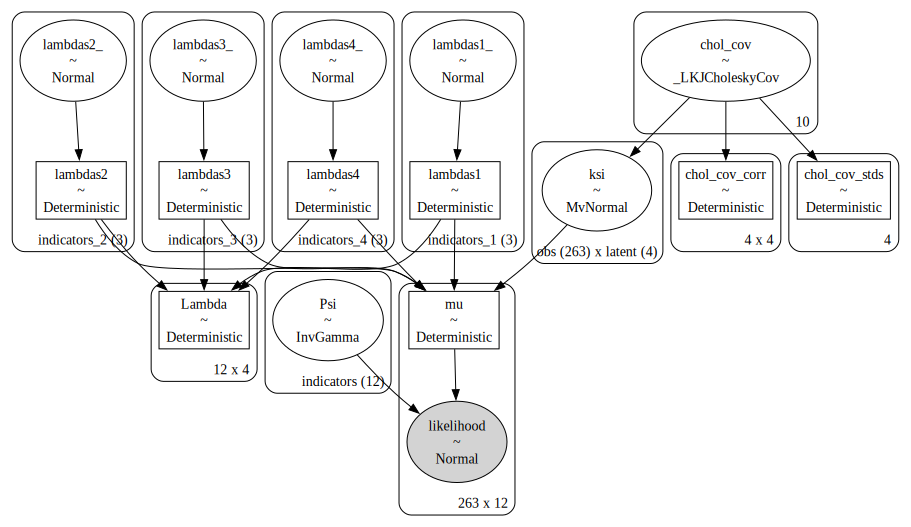

In [41]:
obs_idx = list(range(len(sample_df)))
observed_data = sample_df[coords['indicators']].values
conditional = False

with pm.Model(coords=coords) as cfa_model_v0:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", 0, chol=chol, dims=("obs", "latent"))

    # Construct Pseudo Observation matrix based on Factor Loadings
    m1 = ksi[obs_idx, 0] * lambdas_1[0]
    m2 = ksi[obs_idx, 0] * lambdas_1[1]
    m3 = ksi[obs_idx, 0] * lambdas_1[2]
    m4 = ksi[obs_idx, 1] * lambdas_2[0]
    m5 = ksi[obs_idx, 1] * lambdas_2[1]
    m6 = ksi[obs_idx, 1] * lambdas_2[2]
    m7 = ksi[obs_idx, 2] * lambdas_3[0]
    m8 = ksi[obs_idx, 2] * lambdas_3[1]
    m9 = ksi[obs_idx, 2] * lambdas_3[2]
    m10 = ksi[obs_idx, 3] * lambdas_4[0]
    m11 = ksi[obs_idx, 3] * lambdas_4[1]
    m12 = ksi[obs_idx, 3] * lambdas_4[2]

    mu = pm.Deterministic("mu", pm.math.stack([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12]).T)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    _ = pm.Normal('likelihood', mu=mu, sigma=Psi, observed=observed_data)

pm.model_to_graphviz(cfa_model_v0)

In [57]:
sampler_kwargs = {'draws': 1000}

def sample_model(model, sampler_kwargs):
    with model: 
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(**sampler_kwargs, idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata

idata_cfa_model_v0 = sample_model(cfa_model_v0, sampler_kwargs=sampler_kwargs)

Sampling: [Psi, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, Psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

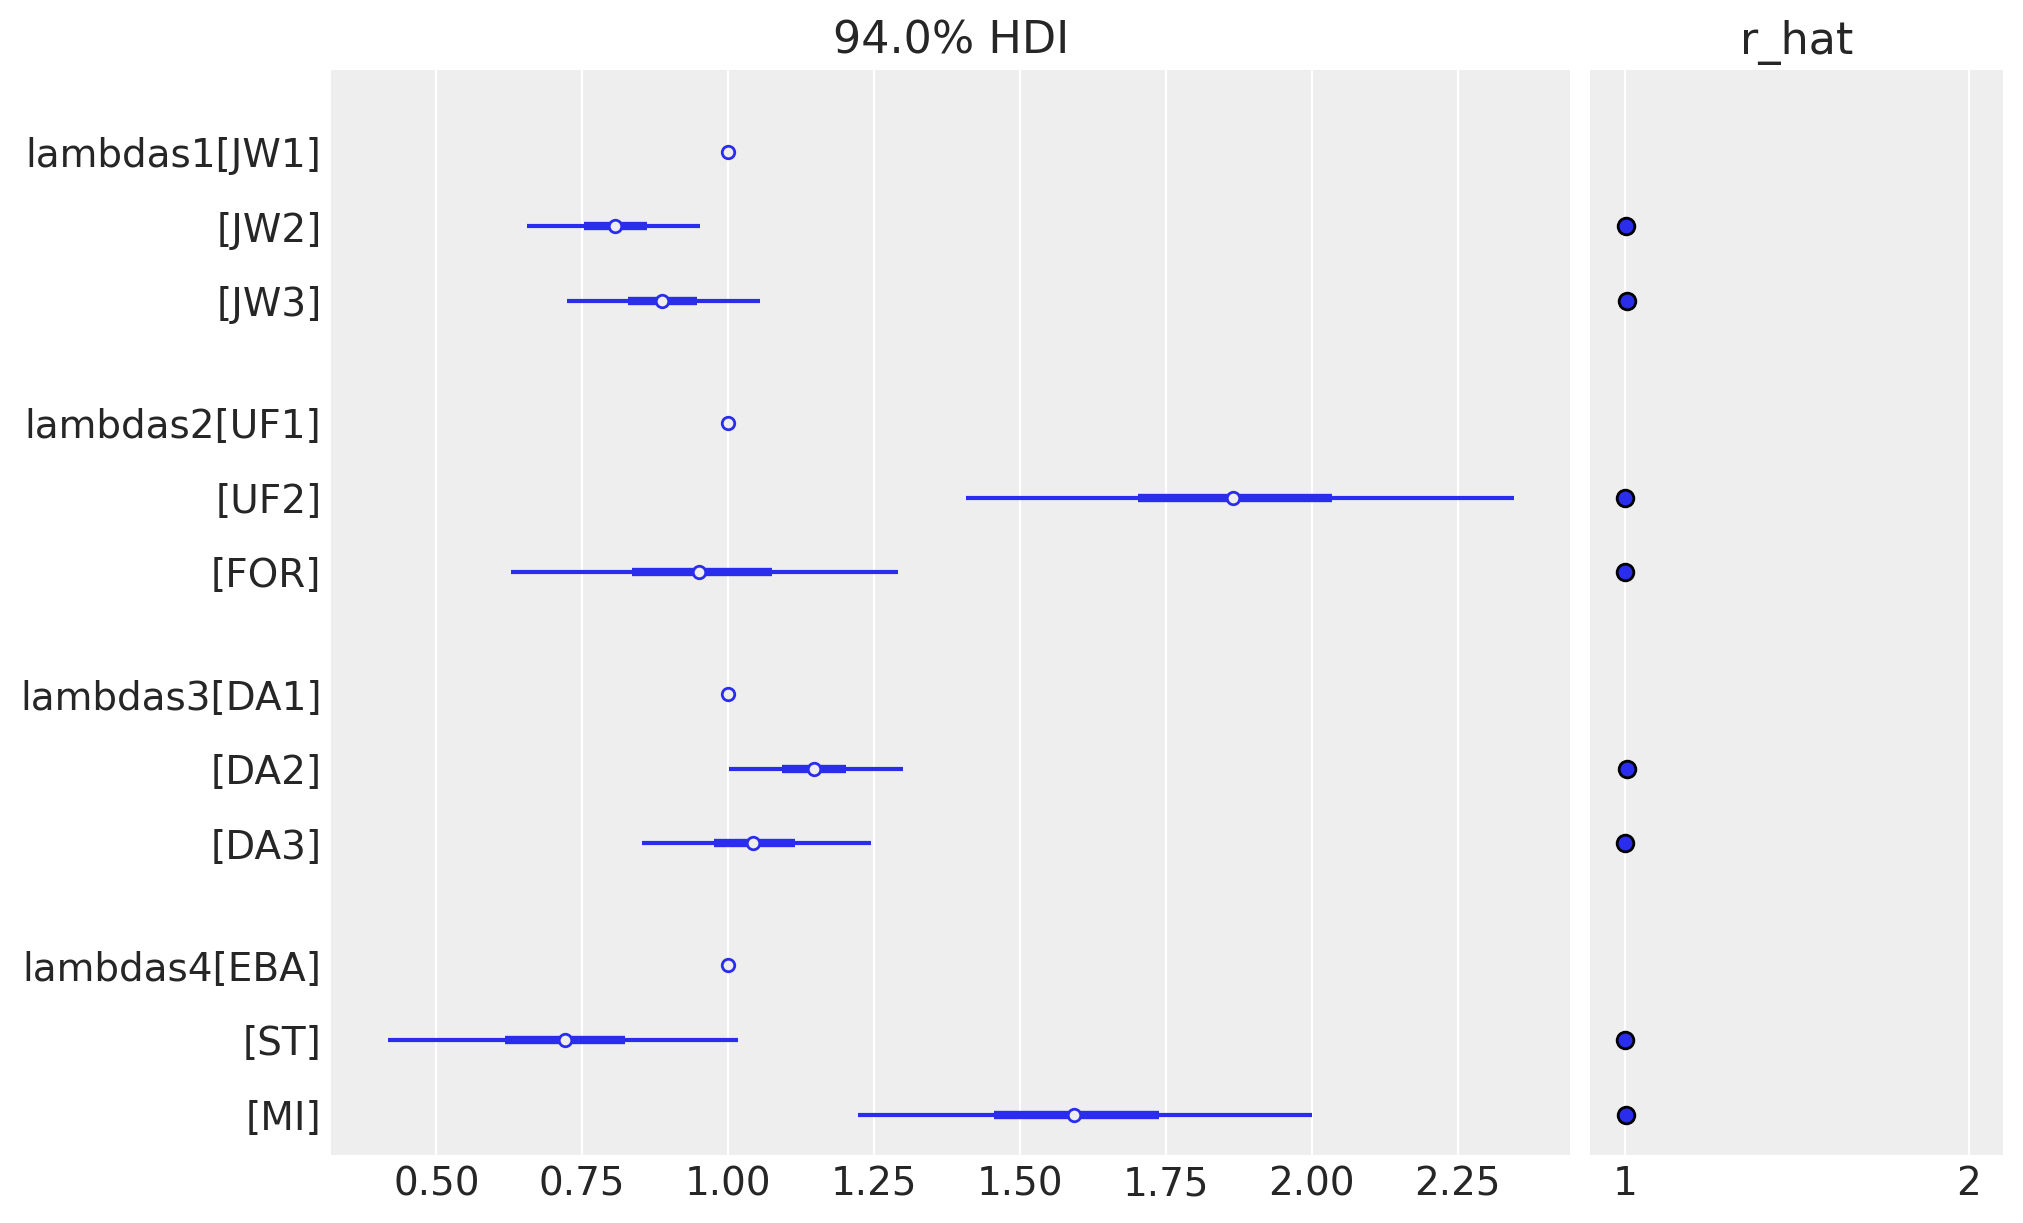

In [50]:
az.plot_forest(idata_cfa_model_v0, var_names=['lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], combined=True, figsize=(10, 6), r_hat=True);

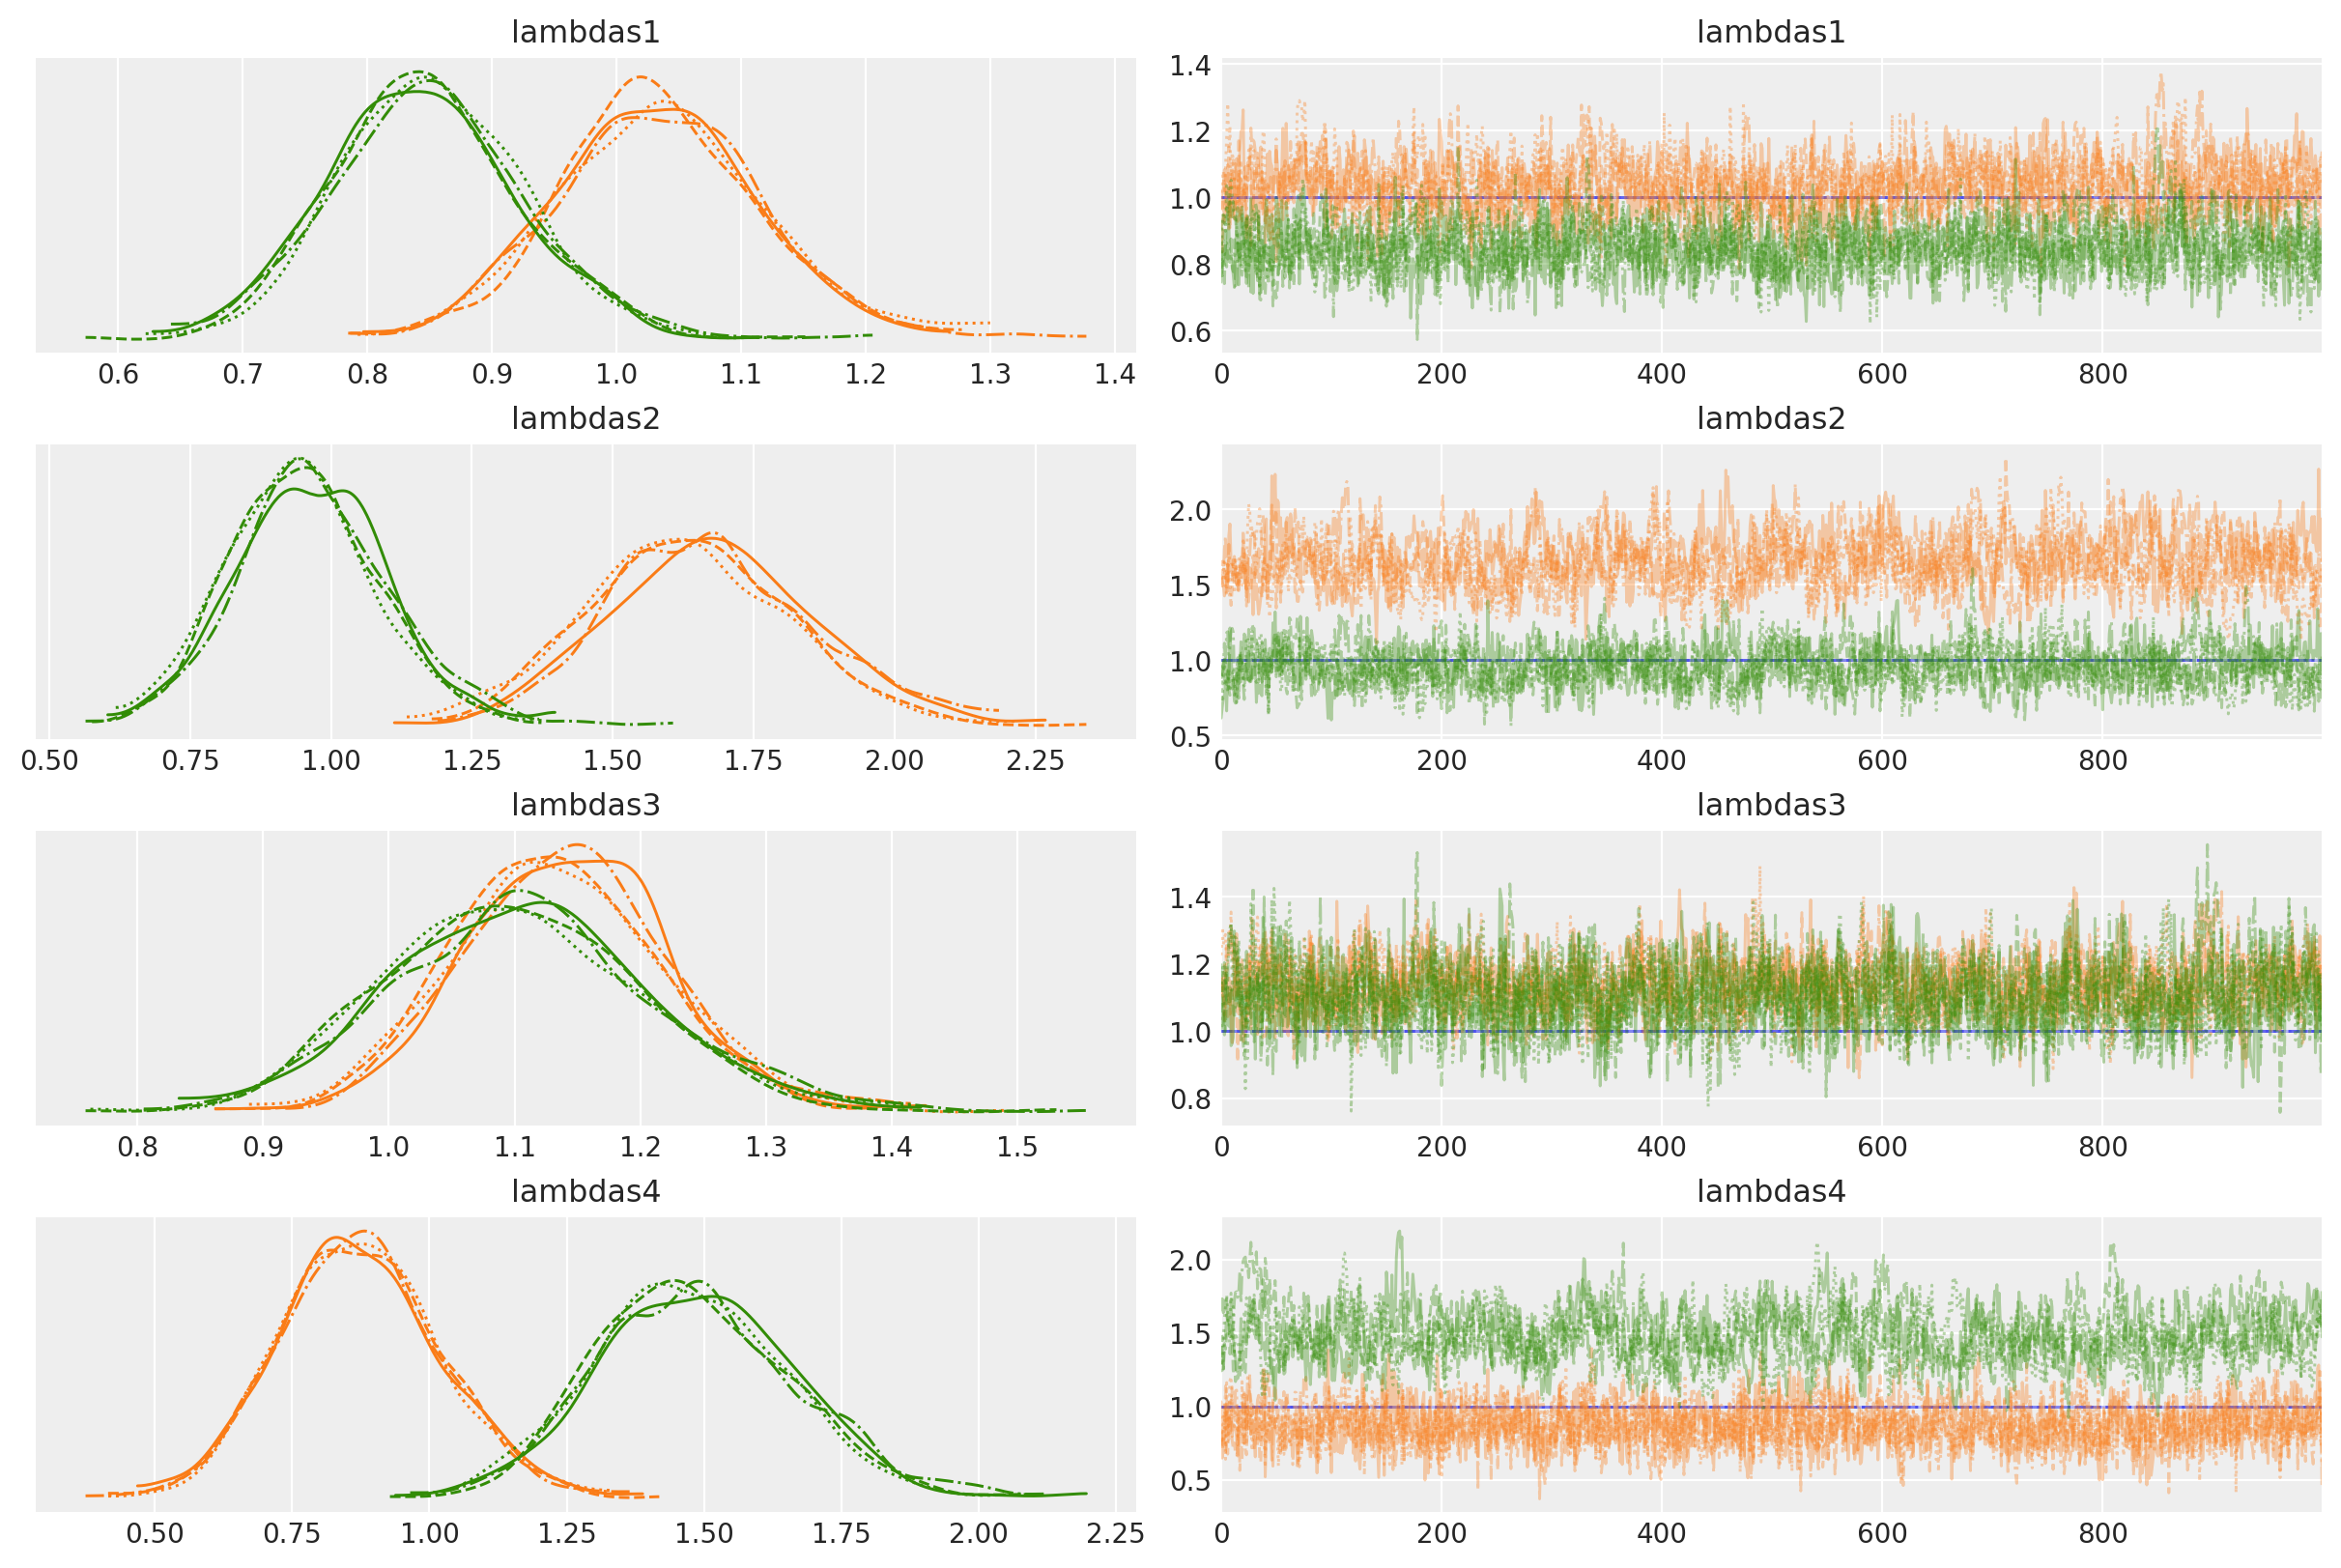

In [ ]:
az.plot_trace(idata_cfa_model_v0, var_names=['lambdas1', 'lambdas2', 'lambdas3', 'lambdas4']);

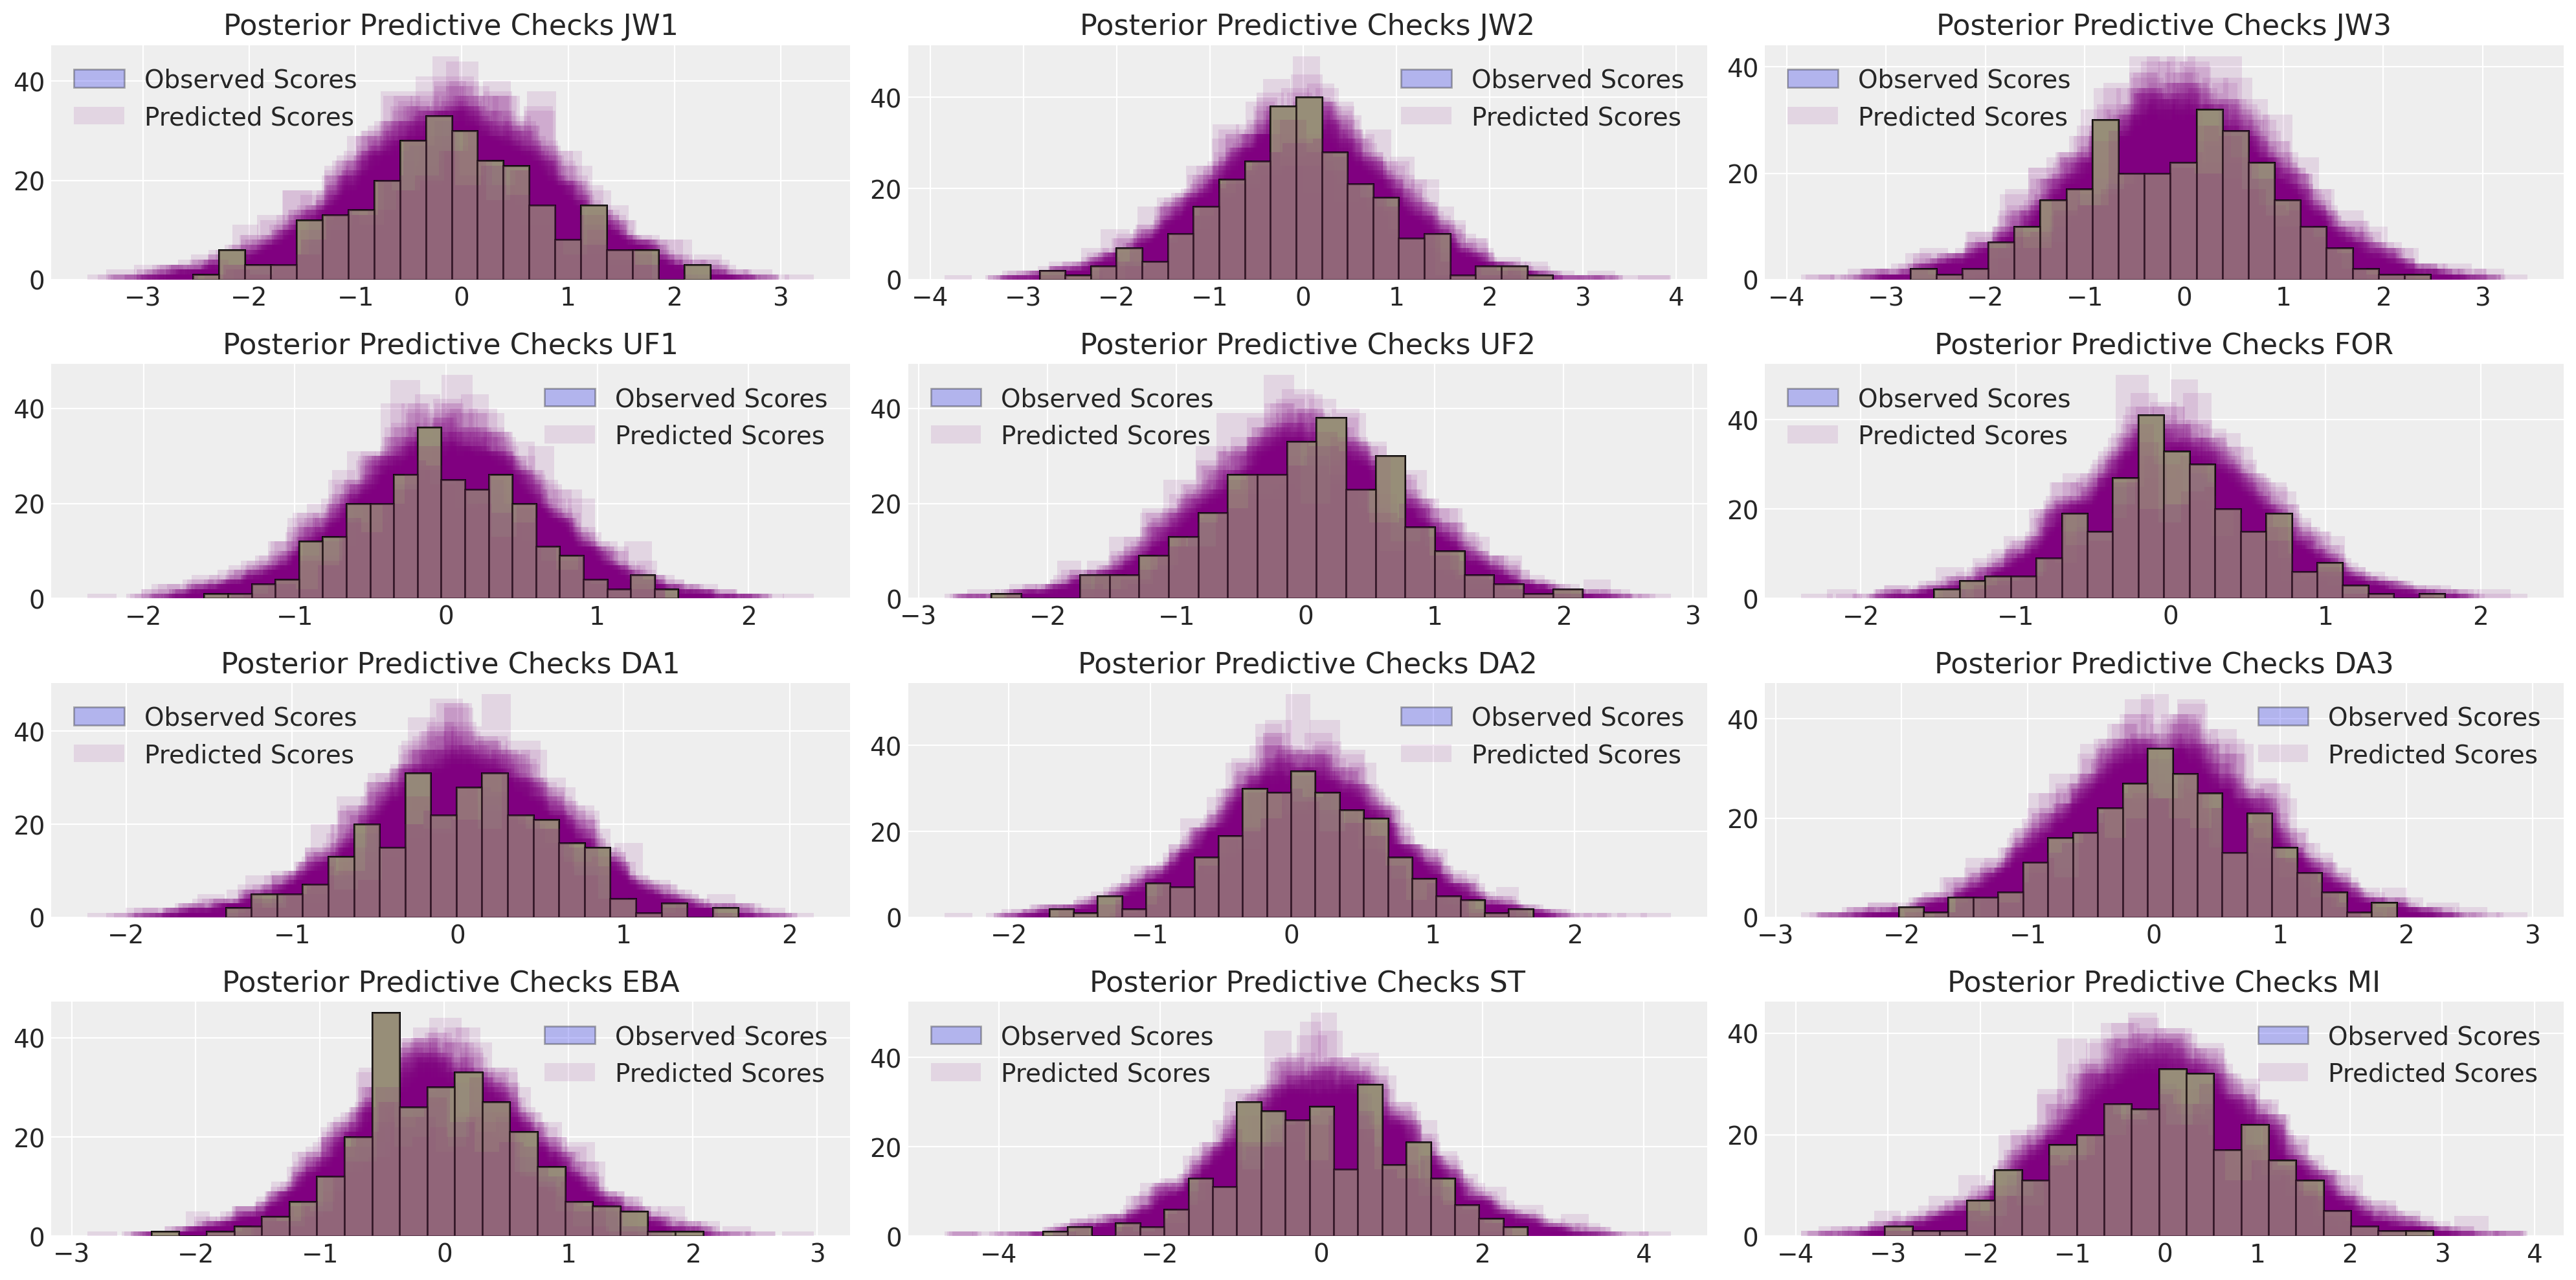

In [53]:
make_ppc(idata_cfa_model_v0, sample_df, dims=(4, 3));

## CFA v1

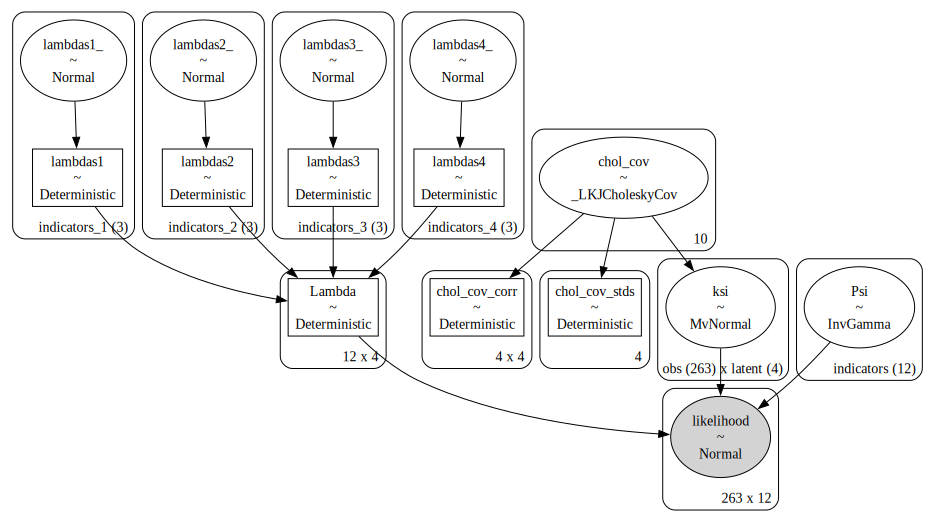

In [54]:

with pm.Model(coords=coords) as cfa_model_v1:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", 0, chol=chol, dims=("obs", "latent"))

    # Construct Pseudo Observation matrix based on Factor Loadings
    mu = pt.dot(ksi, Lambda.T)  # (n_obs, n_indicators)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    _ = pm.Normal('likelihood', mu=mu, sigma=Psi, observed=observed_data)

pm.model_to_graphviz(cfa_model_v1)

In [58]:
idata_cfa_model_v1 = sample_model(cfa_model_v1, sampler_kwargs=sampler_kwargs)

Sampling: [Psi, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, Psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

In [64]:
loo_1 = az.loo(idata_cfa_model_v0, pointwise=True)
loo_2 = az.loo(idata_cfa_model_v1, pointwise=True)

# compare the two models
az.compare({"cfa_model_v1": idata_cfa_model_v1, "cfa_model_v0": idata_cfa_model_v0}, ic="loo")

rank     elpd_loo       p_loo  elpd_diff    weight         se  \
cfa_model_v0     0 -2871.160999  664.270481   0.000000  0.736183  40.935493   
cfa_model_v1     1 -2872.206676  662.292222   1.045677  0.263817  40.879037   

                   dse  warning scale  
cfa_model_v0  0.000000     True   log  
cfa_model_v1  2.126818     True   log

## SEM V0

In [75]:

with pm.Model(coords=coords) as sem_model_v0:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", 0, chol=chol, dims=("obs", "latent"))

    B = make_B()
    ksi_hat = pm.Deterministic('ksi_hat', pm.math.dot(ksi, B))

    # Construct Pseudo Observation matrix based on Factor Loadings
    m1 = ksi[obs_idx, 0] * lambdas_1[0] + ksi_hat[obs_idx, 0]
    m2 = ksi[obs_idx, 0] * lambdas_1[1] + ksi_hat[obs_idx, 0]
    m3 = ksi[obs_idx, 0] * lambdas_1[2] + ksi_hat[obs_idx, 0]
    m4 = ksi[obs_idx, 1] * lambdas_2[0] + ksi_hat[obs_idx, 1]
    m5 = ksi[obs_idx, 1] * lambdas_2[1] + ksi_hat[obs_idx, 1]
    m6 = ksi[obs_idx, 1] * lambdas_2[2] + ksi_hat[obs_idx, 1]
    m7 = ksi[obs_idx, 2] * lambdas_3[0] + ksi_hat[obs_idx, 2]
    m8 = ksi[obs_idx, 2] * lambdas_3[1] + ksi_hat[obs_idx, 2]
    m9 = ksi[obs_idx, 2] * lambdas_3[2] + ksi_hat[obs_idx, 2]
    m10 = ksi[obs_idx, 3] * lambdas_4[0] + ksi_hat[obs_idx, 3]
    m11 = ksi[obs_idx, 3] * lambdas_4[1] + ksi_hat[obs_idx, 3]
    m12 = ksi[obs_idx, 3] * lambdas_4[2] + ksi_hat[obs_idx, 3]

    mu = pm.Deterministic("mu", pm.math.stack([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12]).T)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    _ = pm.Normal('likelihood', mu=mu, sigma=Psi, observed=observed_data)

In [76]:
idata_sem_model_v0 = sample_model(sem_model_v0, sampler_kwargs)

Sampling: [Psi, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, mu_betas, Psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

## SEM V1 

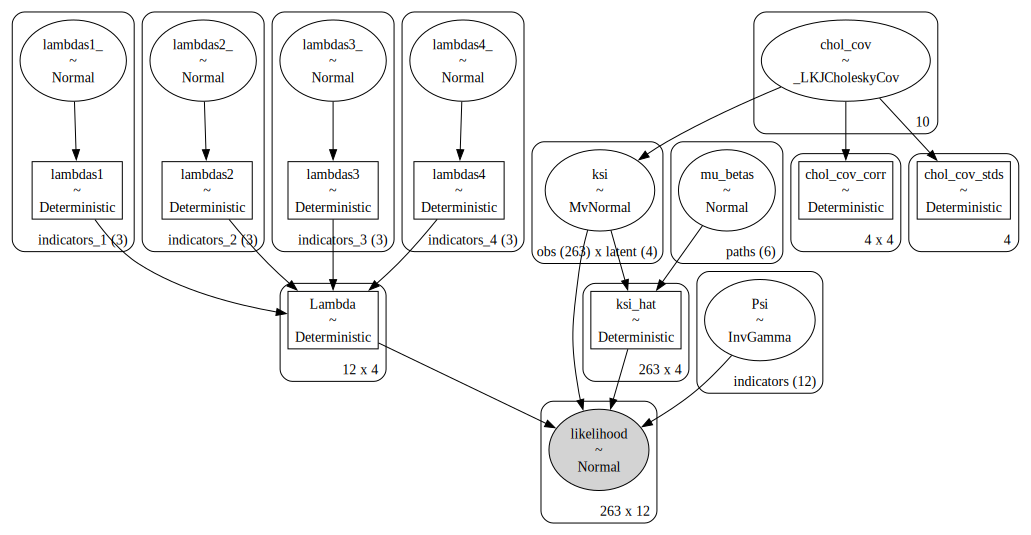

In [68]:
with pm.Model(coords=coords) as sem_model_v1:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", 0, chol=chol, dims=("obs", "latent"))

    B = make_B()
    ksi_hat = pm.Deterministic('ksi_hat', pm.math.dot(ksi, B))

    # Construct Pseudo Observation matrix based on Factor Loadings
    mu = pt.dot(ksi, Lambda.T) + pt.dot(ksi_hat, Lambda.T)  # (n_obs, n_indicators)

    ## Error Terms
    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    _ = pm.Normal('likelihood', mu=mu, sigma=Psi, observed=observed_data)

pm.model_to_graphviz(sem_model_v1)

In [70]:
idata_sem_model_v1 = sample_model(sem_model_v1, sampler_kwargs)

Sampling: [Psi, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, mu_betas, Psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

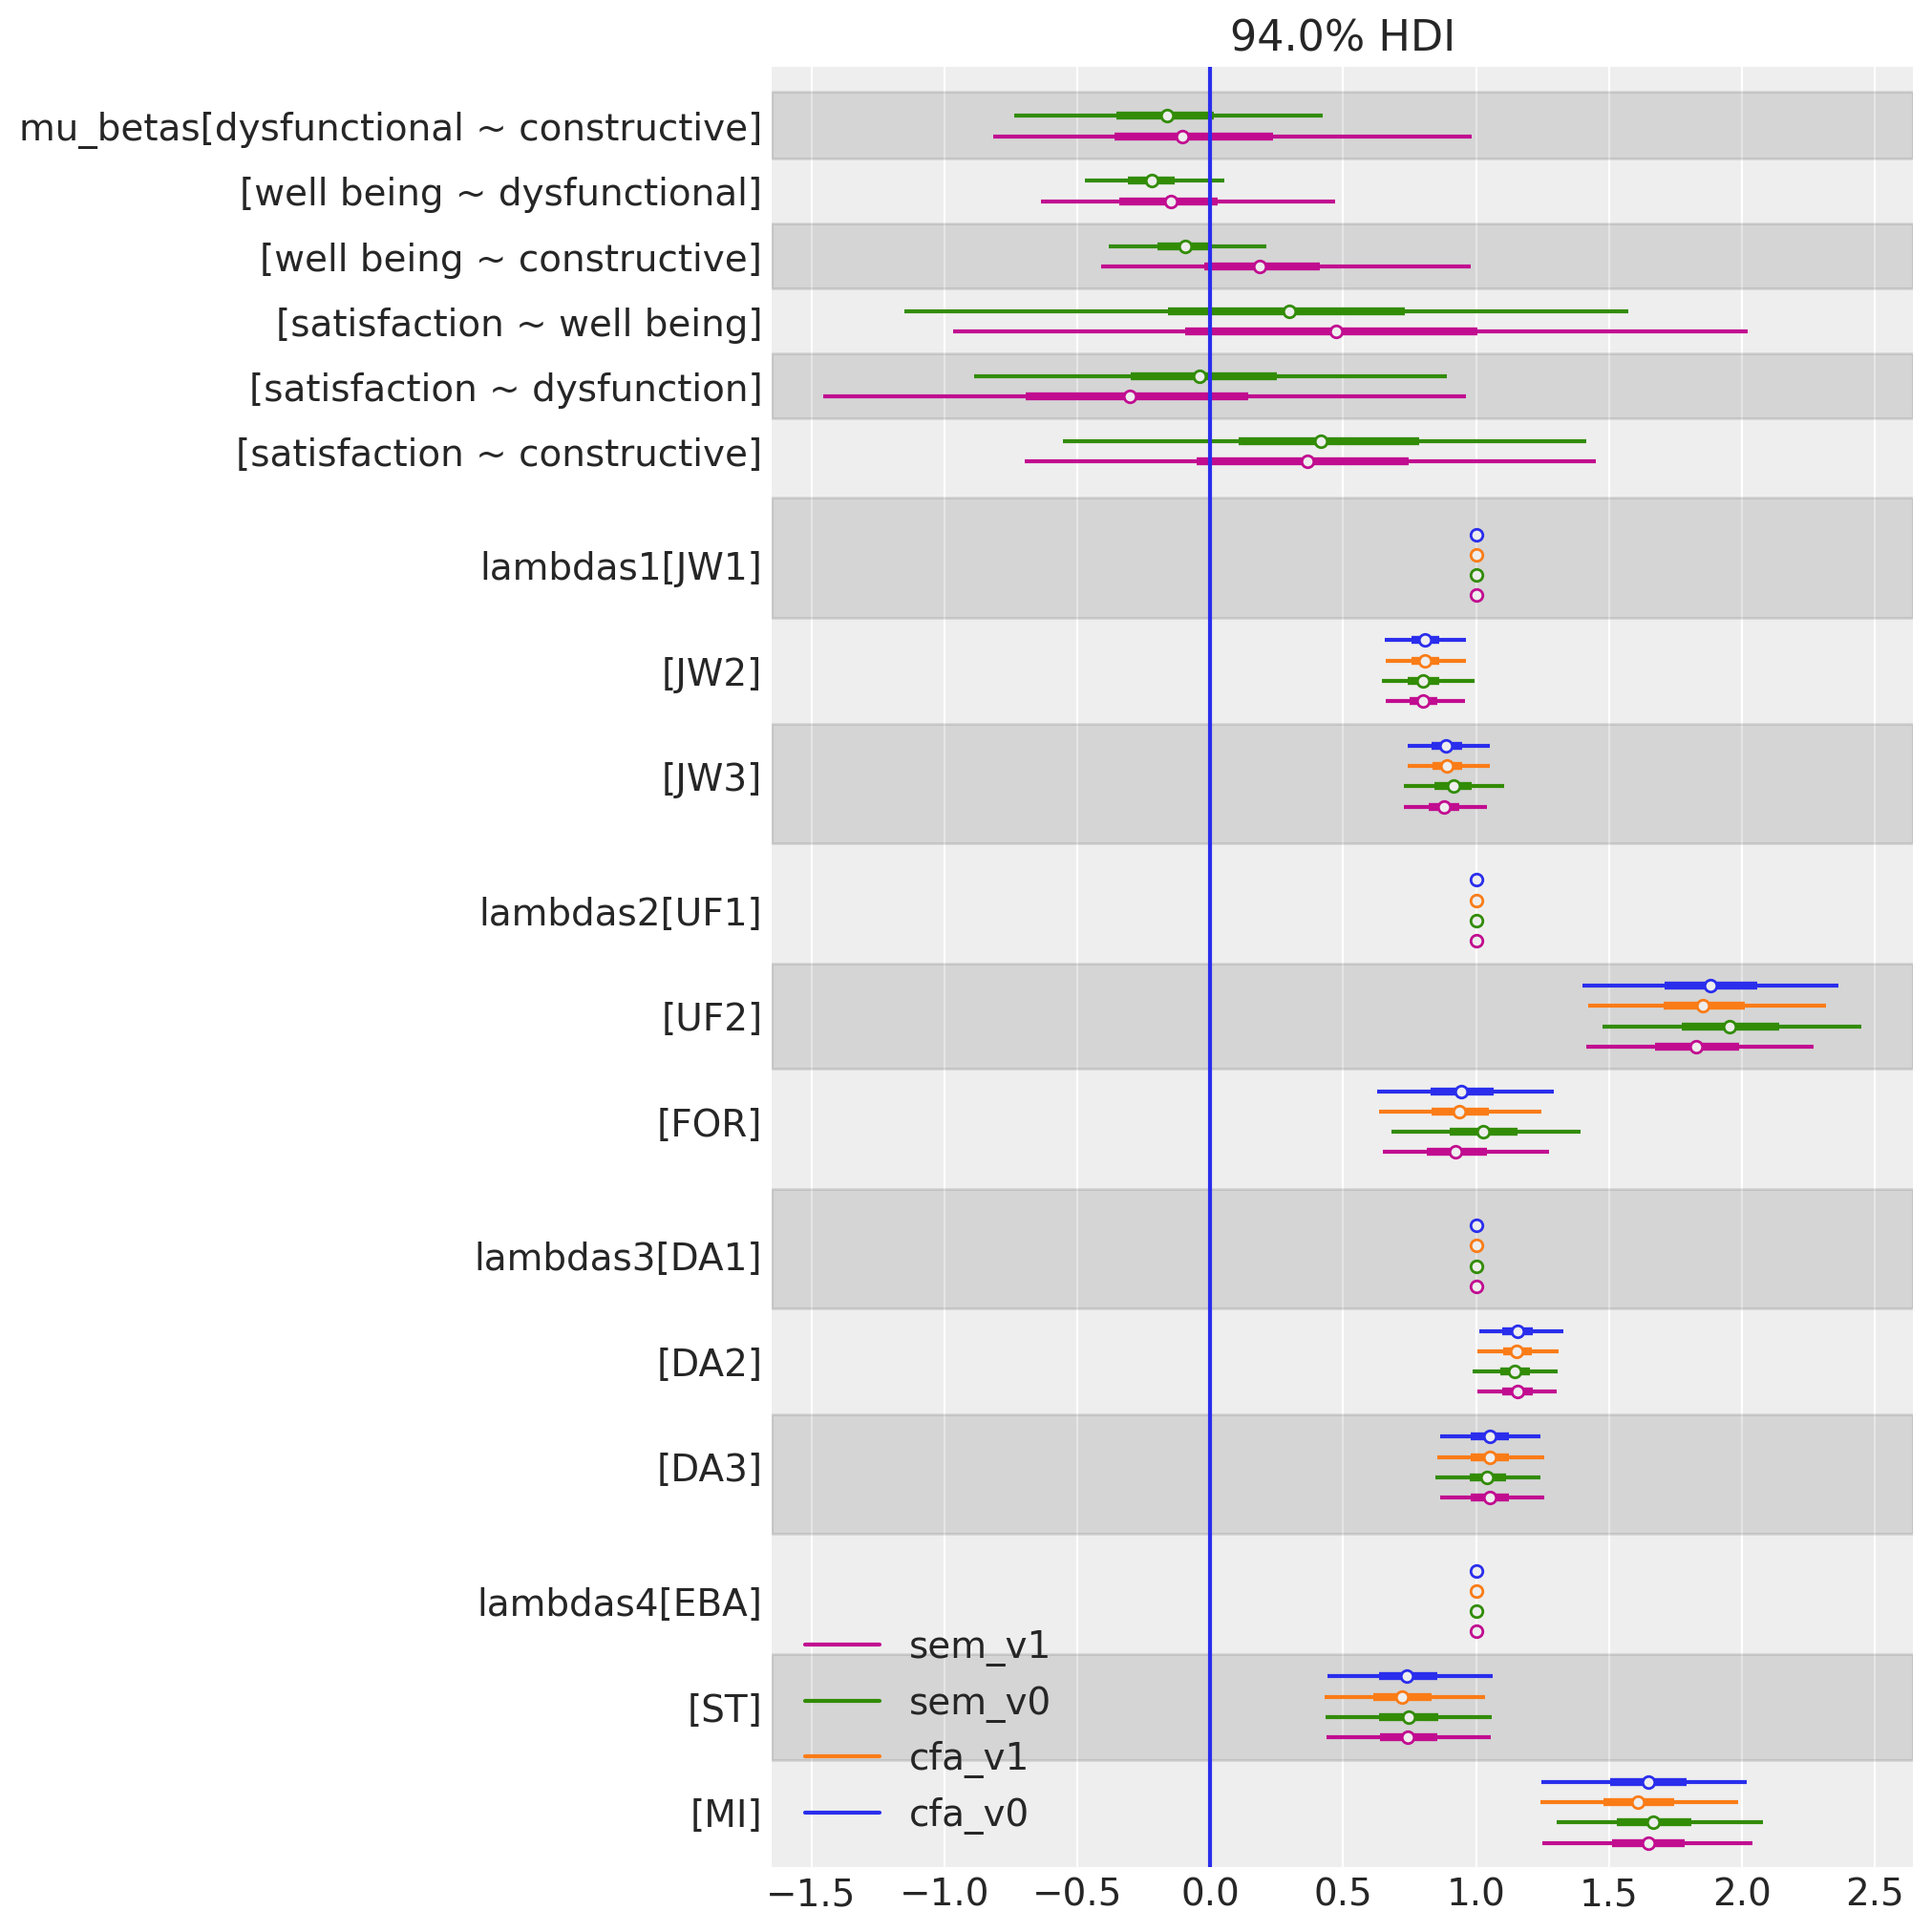

In [79]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1], var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

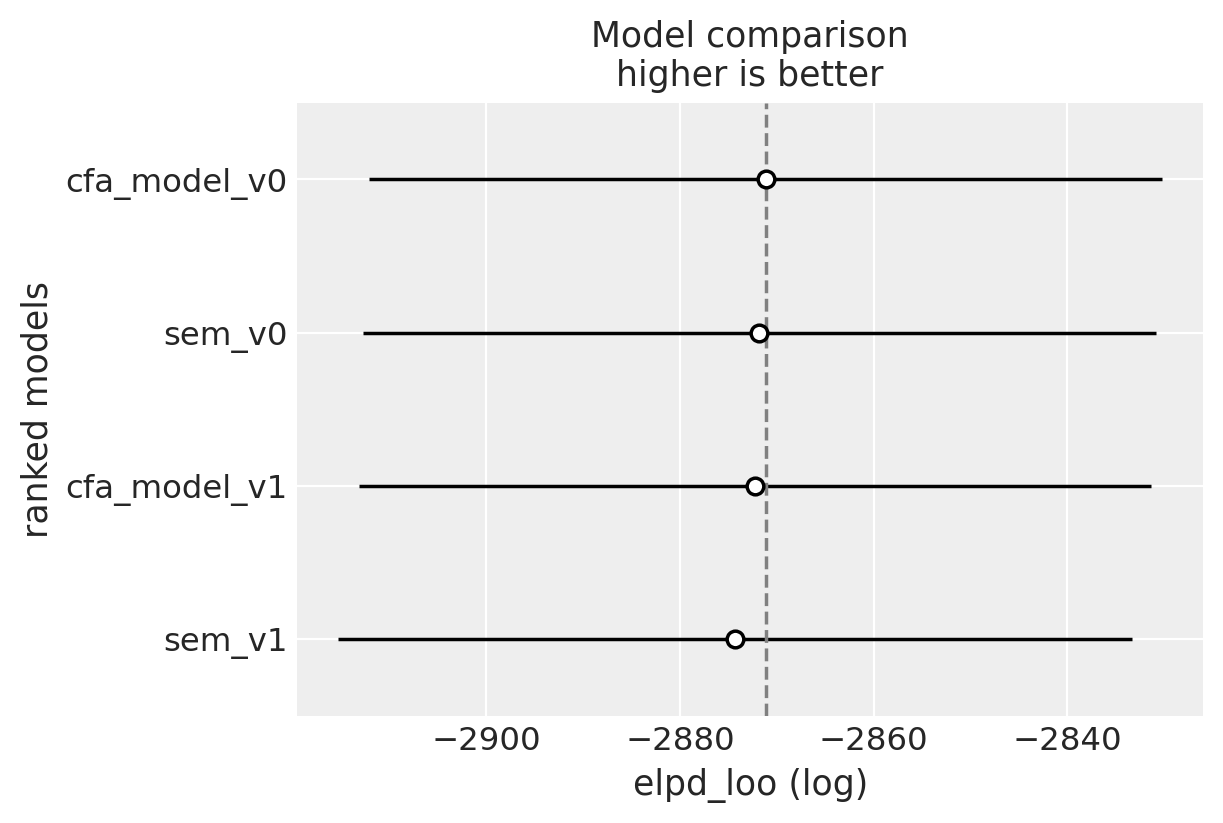

In [81]:
# compare the two models
compare_df = az.compare({"cfa_model_v1": idata_cfa_model_v1, "cfa_model_v0": idata_cfa_model_v0, 
            'sem_v0': idata_sem_model_v0, 'sem_v1': idata_sem_model_v1}, ic="loo")

az.plot_compare(compare_df)

## SEM with Covariance Structures


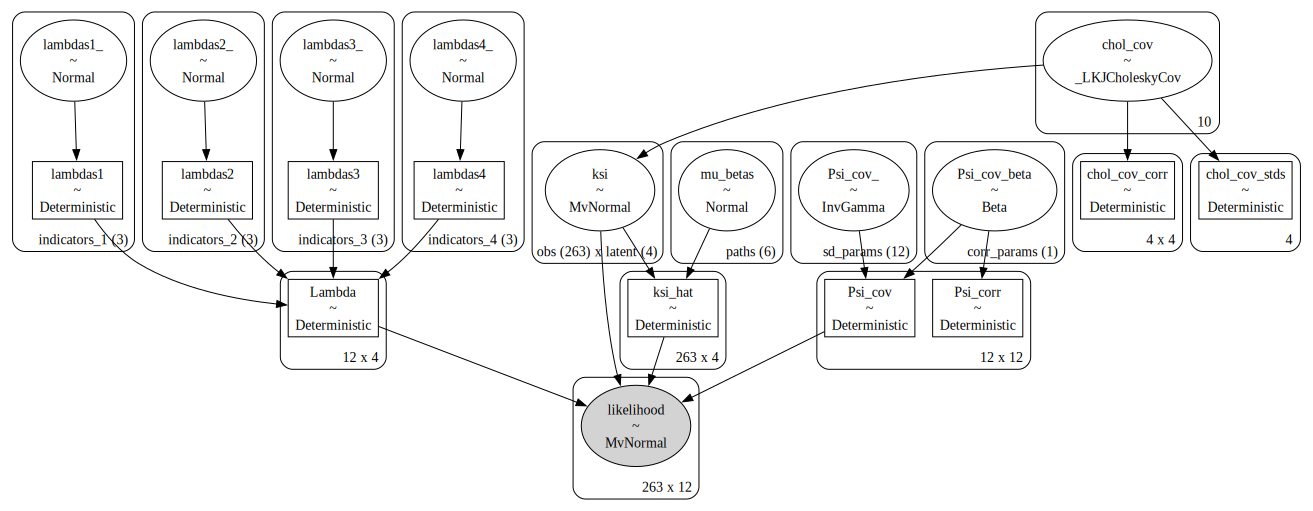

In [85]:
with pm.Model(coords=coords) as sem_model_v2:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", 0, chol=chol, dims=("obs", "latent"))

    B = make_B()
    ksi_hat = pm.Deterministic('ksi_hat', pm.math.dot(ksi, B))

    # Construct Pseudo Observation matrix based on Factor Loadings
    mu = pt.dot(ksi, Lambda.T) + pt.dot(ksi_hat, Lambda.T)  # (n_obs, n_indicators)

    ## Error Terms
    Psi = make_Psi('indicators')
    _ = pm.MvNormal('likelihood', mu=mu, cov=Psi, observed=observed_data)

pm.model_to_graphviz(sem_model_v2)

In [86]:
idata_sem_model_v2 = sample_model(sem_model_v2, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, mu_betas, Psi_cov_, Psi_cov_beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

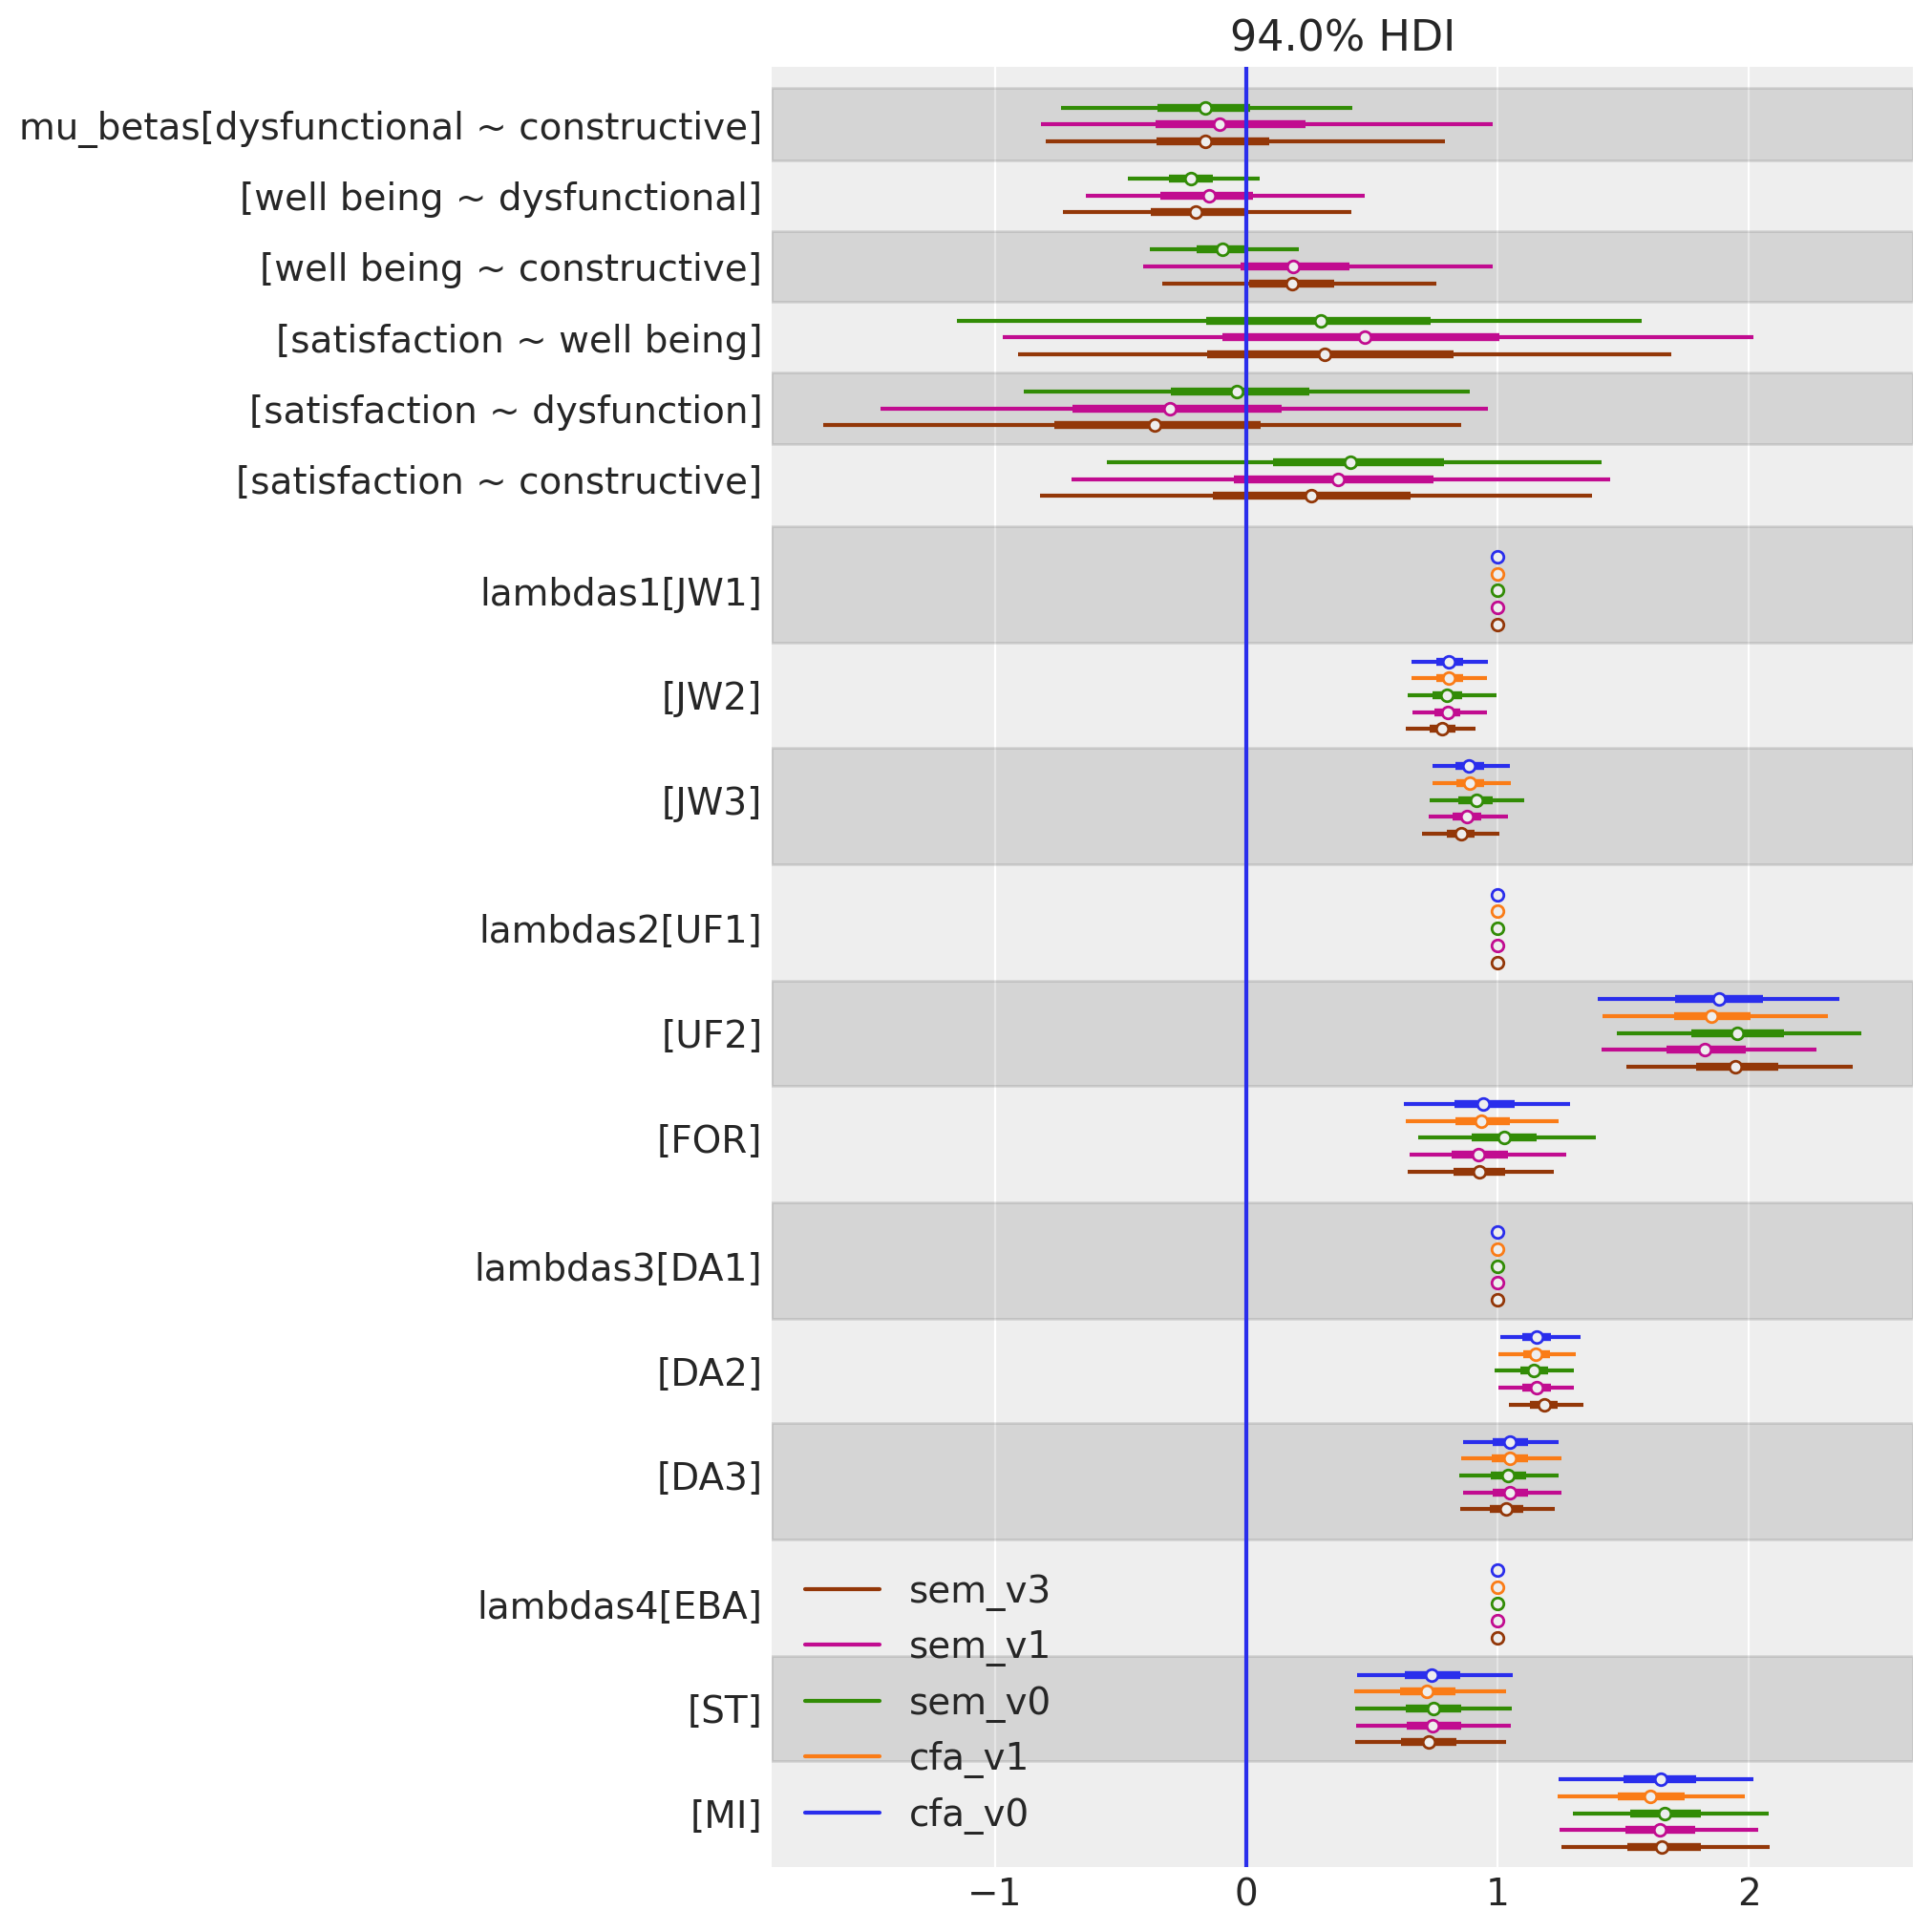

In [ ]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2], var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

## SEM v3

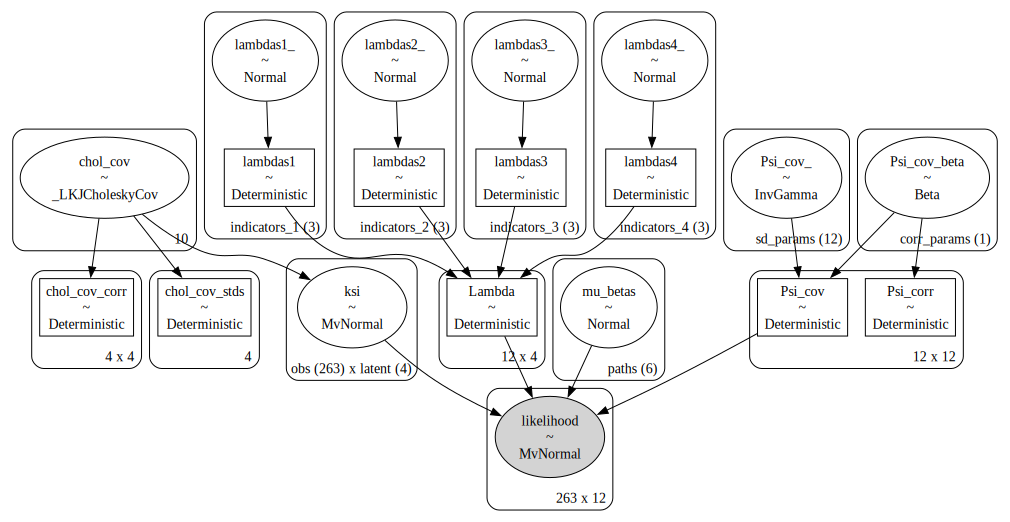

In [89]:
with pm.Model(coords=coords) as sem_model_v3:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", 0, chol=chol, dims=("obs", "latent"))

    B = make_B()
    latent_dim = len(coords['latent'])
    I = pt.eye(latent_dim)
    # Solve (I - B) * ksi.T = zeta.T  => ksi = ((I-B)^-1) * zeta
    lhs = I - B + 1e-8 * pt.eye(latent_dim)  # (latent_dim, latent_dim)
    ksi_hat = pt.slinalg.solve(lhs, ksi.T).T

    mu = pt.dot(ksi_hat, Lambda.T)

    ## Error Terms
    Psi = make_Psi('indicators')
    _ = pm.MvNormal('likelihood', mu=mu, cov=Psi, observed=observed_data)

pm.model_to_graphviz(sem_model_v3)

In [90]:
idata_sem_model_v3 = sample_model(sem_model_v3, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, mu_betas, Psi_cov_, Psi_cov_beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

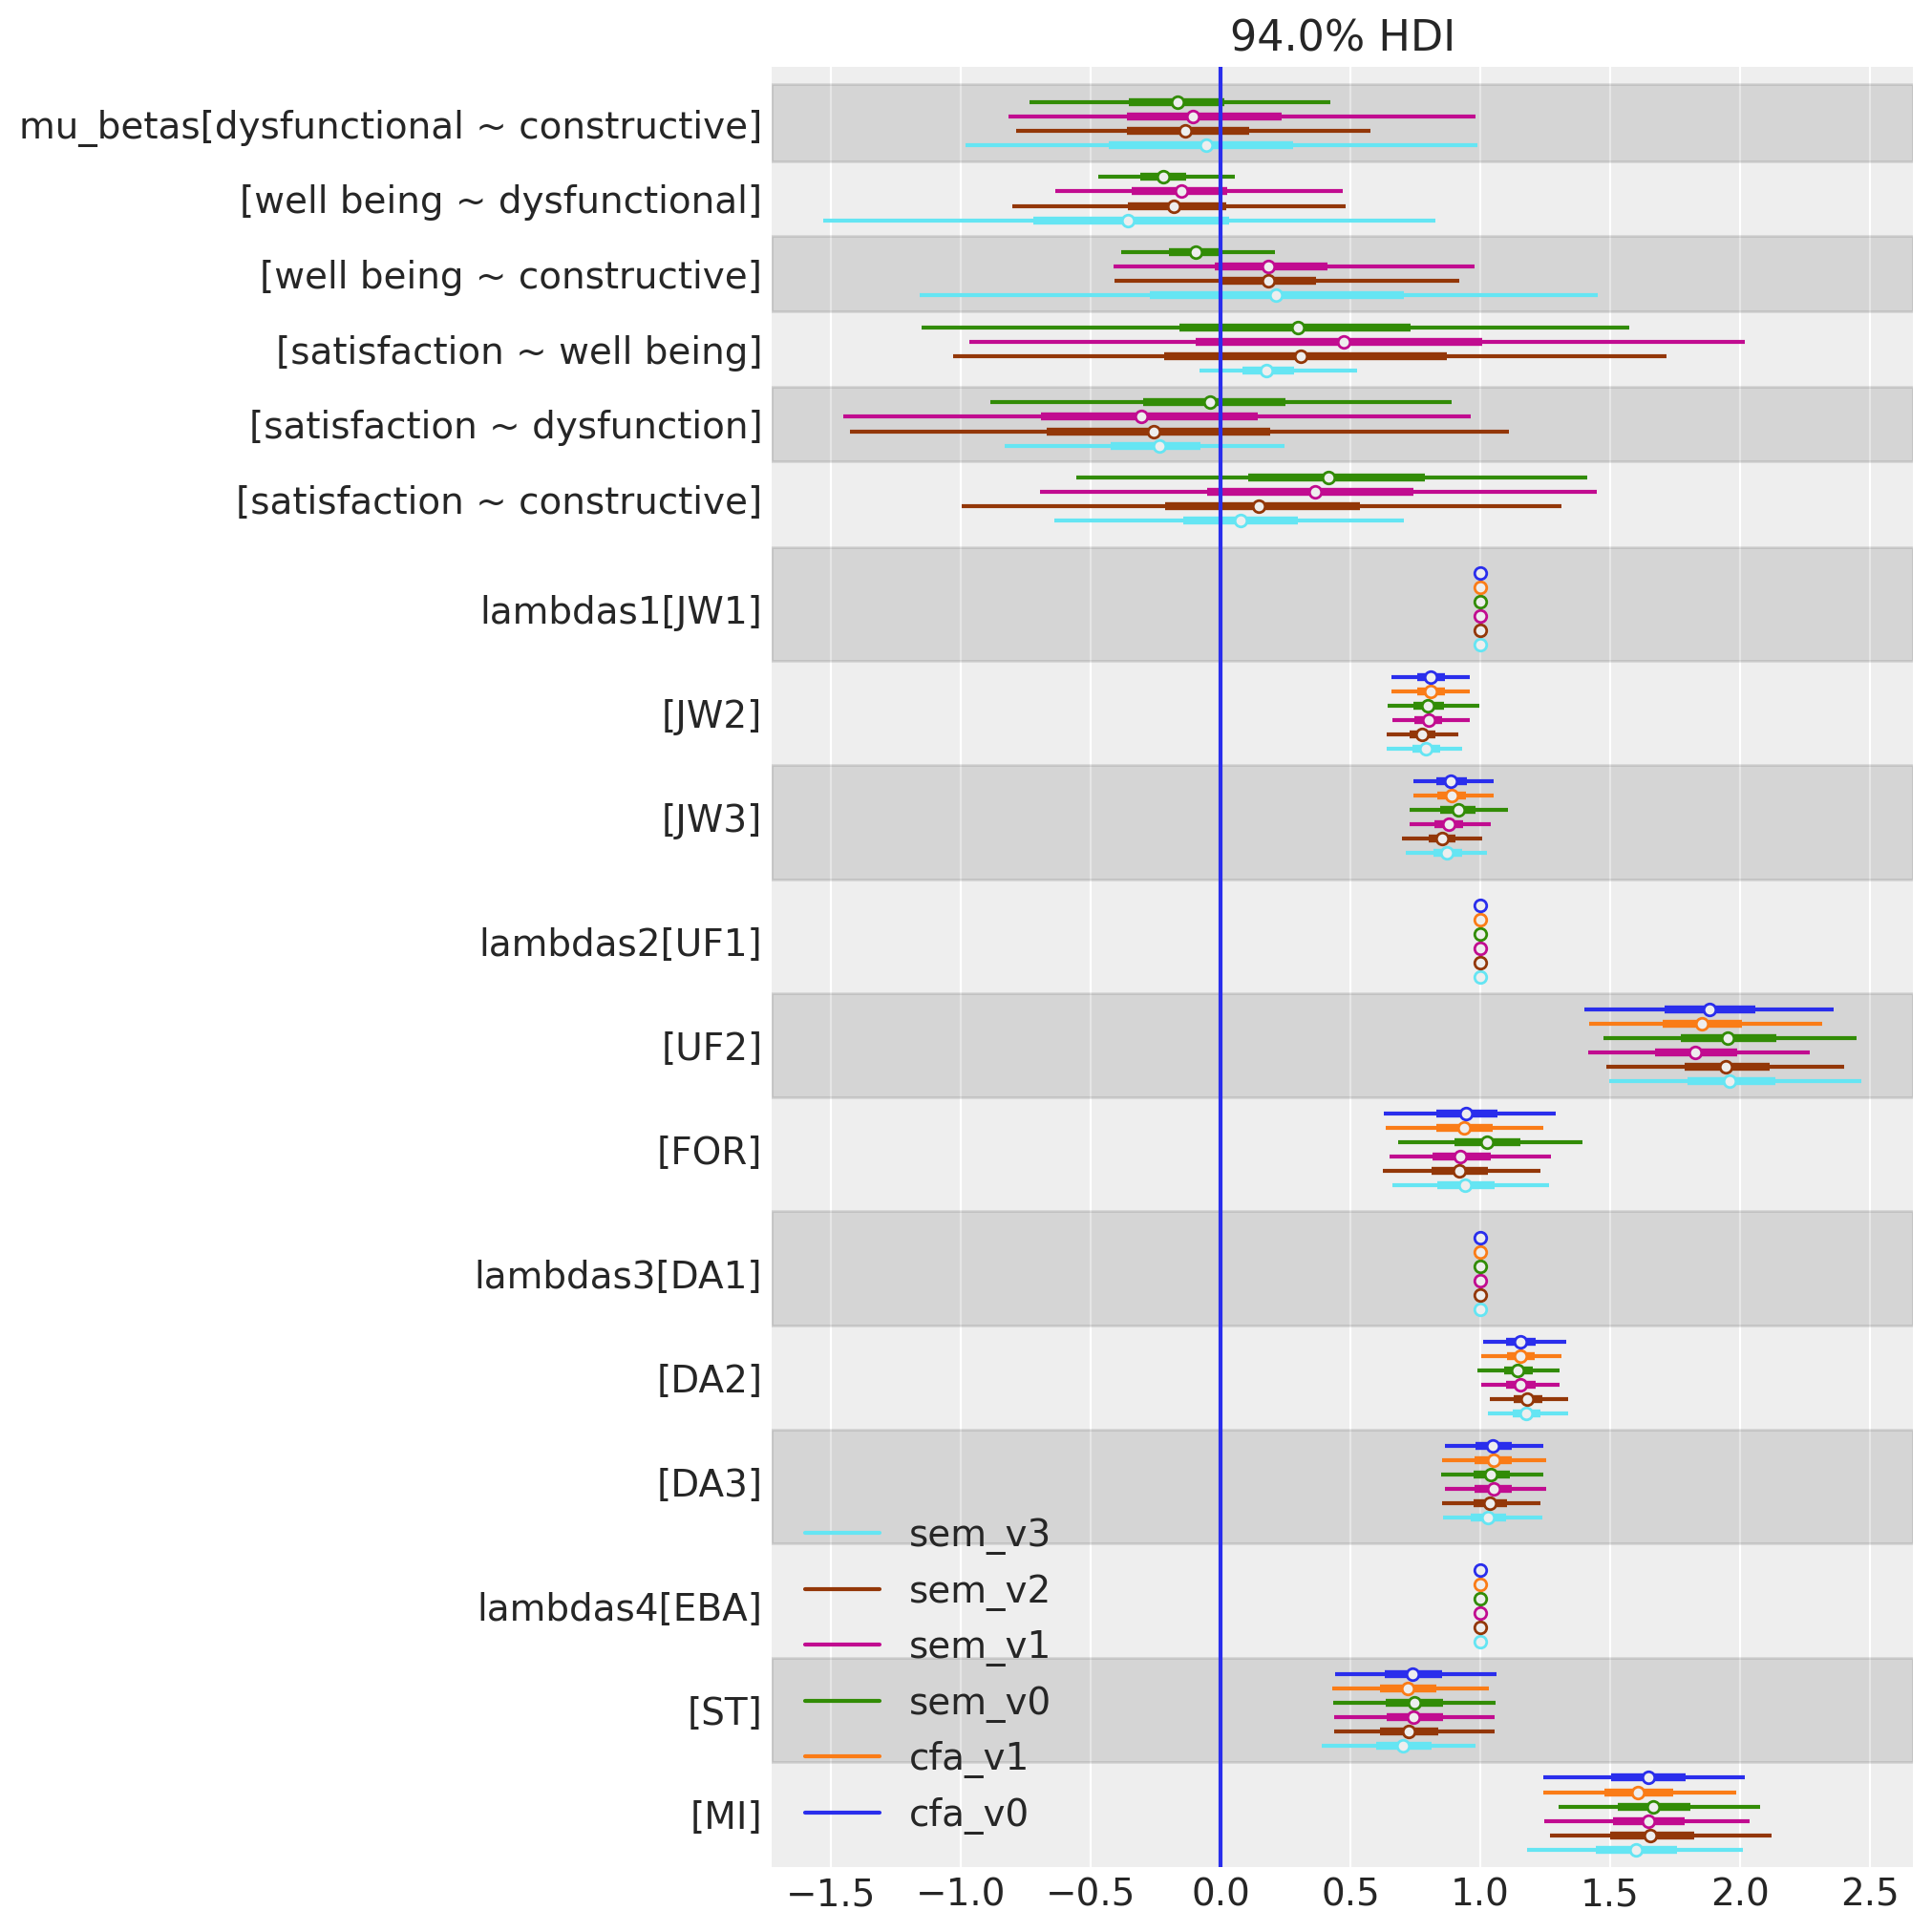

In [91]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2, idata_sem_model_v3], var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2', 'sem_v3'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

In [94]:
# compare the two models
compare_df = az.compare({
            'sem_v2': idata_sem_model_v2, 'sem_v3': idata_sem_model_v3}, ic="loo")
compare_df

rank     elpd_loo       p_loo  elpd_diff    weight         se  \
sem_v3     0 -2882.321091  673.836362   0.000000  0.620429  35.709204   
sem_v2     1 -2888.742565  686.031392   6.421474  0.379571  36.116309   

             dse  warning scale  
sem_v3  0.000000     True   log  
sem_v2  7.332431     True   log

## SEM V4

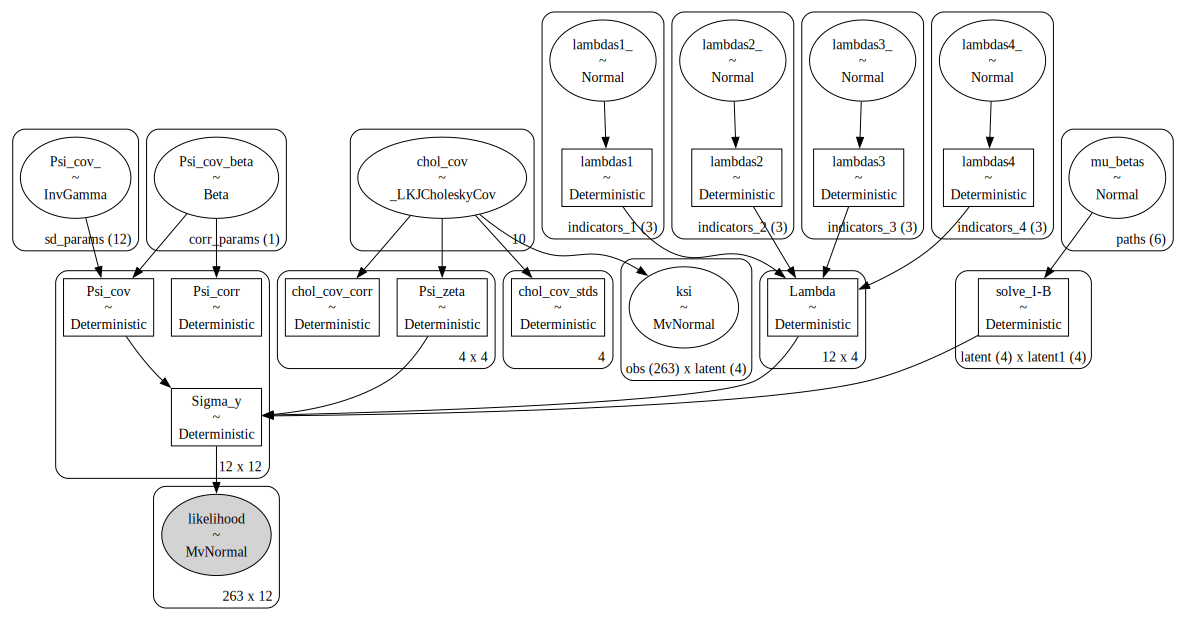

In [ ]:
with pm.Model(coords=coords) as sem_model_v4:
    
    # --- Factor loadings ---
    lambdas_1 = make_lambda('indicators_1', 'lambdas1', priors=[1, .5])
    lambdas_2 = make_lambda('indicators_2', 'lambdas2', priors=[1, .5])
    lambdas_3 = make_lambda('indicators_3', 'lambdas3', priors=[1, .5])
    lambdas_4 = make_lambda('indicators_4', 'lambdas4', priors=[1, .5])

    Lambda = pt.zeros((12, 4))
    Lambda = pt.set_subtensor(Lambda[0:3, 0], lambdas_1)
    Lambda = pt.set_subtensor(Lambda[3:6, 1], lambdas_2)
    Lambda = pt.set_subtensor(Lambda[6:9, 2], lambdas_3)
    Lambda = pt.set_subtensor(Lambda[9:12, 3], lambdas_4)
    Lambda = pm.Deterministic('Lambda', Lambda)

    sd_dist = pm.Exponential.dist(1.0, shape=4)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=4, eta=2, sd_dist=sd_dist, compute_corr=True)

    Psi_zeta = pm.Deterministic("Psi_zeta", chol.dot(chol.T))
    Psi = make_Psi('indicators')

    B = make_B()
    latent_dim = len(coords['latent'])
    I = pt.eye(latent_dim)
    lhs = I - B + 1e-8 * pt.eye(latent_dim)  # (latent_dim, latent_dim)
    inv_lhs = pt.slinalg.solve(lhs, pt.eye(latent_dim))
    inv_lhs = pm.Deterministic('solve_I-B', inv_lhs, dims=('latent', 'latent1'))

    Sigma_y = pm.Deterministic('Sigma_y', Lambda.dot(inv_lhs).dot(Psi_zeta).dot(inv_lhs.T).dot(Lambda.T) + Psi)
    _ = pm.MvNormal("likelihood", mu=0, cov=Sigma_y, observed=observed_data)

pm.model_to_graphviz(sem_model_v4)

In [99]:
idata_sem_model_v4 = sample_model(sem_model_v4, sampler_kwargs)

Sampling: [Psi_cov_, Psi_cov_beta, chol_cov, ksi, lambdas1_, lambdas2_, lambdas3_, lambdas4_, likelihood, mu_betas]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas1_, lambdas2_, lambdas3_, lambdas4_, chol_cov, ksi, Psi_cov_, Psi_cov_beta, mu_betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

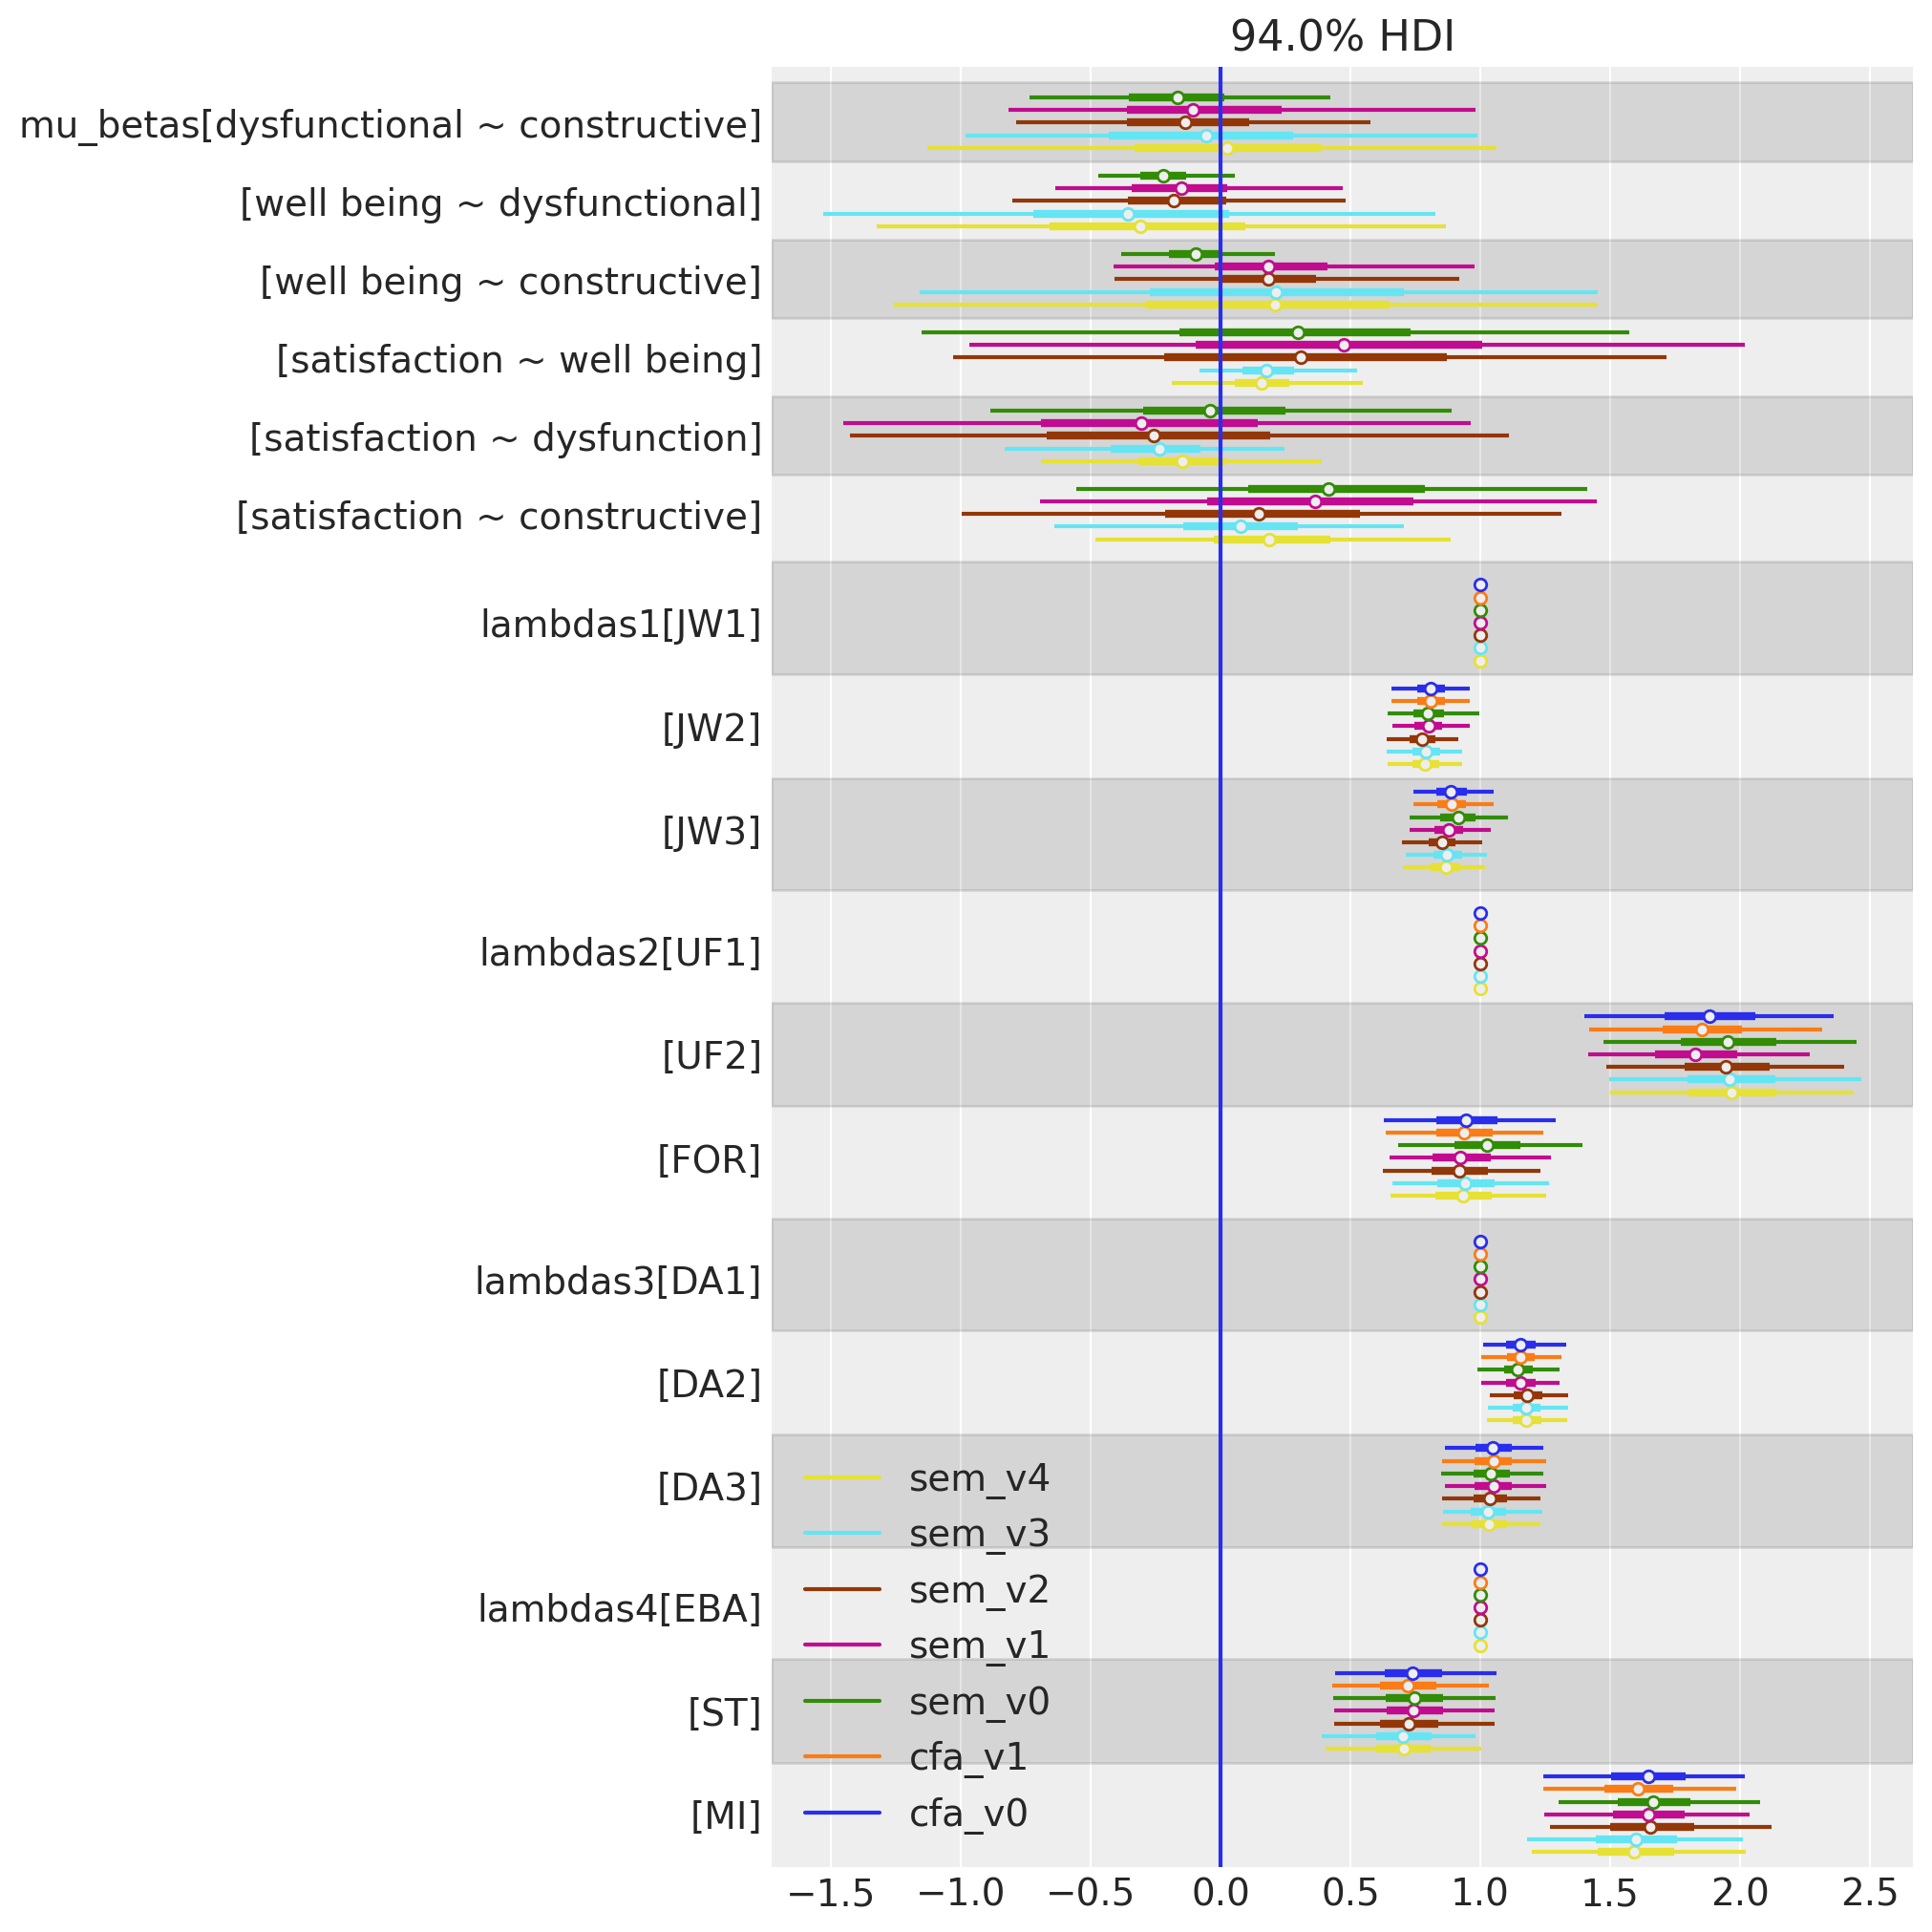

In [100]:
axs = az.plot_forest([idata_cfa_model_v0, idata_cfa_model_v1, idata_sem_model_v0,
                idata_sem_model_v1, idata_sem_model_v2, idata_sem_model_v3, idata_sem_model_v4], var_names=['mu_betas', 'lambdas1', 'lambdas2', 'lambdas3', 'lambdas4'], 
                model_names=['cfa_v0', 'cfa_v1', 'sem_v0', 'sem_v1', 'sem_v2', 'sem_v3', 'sem_v4'], combined=True, figsize=(10, 10))
axs[0].axvline(0)

## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in November 2025 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Dec 28 2022

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.7.0

pytensor: 2.8.11

pymc      : 5.0.1
numpy     : 1.24.0
arviz     : 0.14.0
pandas    : 1.5.2
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:21:25) [Clang 14.0.4 ]
matplotlib: 3.6.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::